# Scenario/Robustness analysis

In [1]:
# Importing external packages

import os
import sys
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import seaborn as sns
import pandas as pd
import numpy as np
import statistics
from collections import defaultdict
from tqdm import tqdm
from pandas.plotting import parallel_coordinates
from matplotlib.lines import Line2D
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis import dimensional_stacking
from sklearn.preprocessing import MinMaxScaler
import importlib
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Importing model scripts, by first adding the main folder path

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from model.model_nile import ModelNile
from experimentation.data_generation import generate_input_data
import plotter

import matplotlib
import matplotlib.font_manager as fm

# sns.set(font_scale=1.2)

fm.fontManager.addfont("Minion Pro Regular.ttf")
matplotlib.rc("font", family="Minion Pro")

from matplotlib import rcParams

rcParams["font.family"] = "Minion Pro"
rcParams["font.sans-serif"] = "Minion Pro"
rcParams["font.size"] = 12

Read the results of the open exploration:

In [3]:
experiments = pd.read_csv("../outputs/experiments_exploration.csv").drop(
    columns="Unnamed: 0"
)
outcomes = pd.read_csv("../outputs/outcomes_exploration.csv").drop(columns="Unnamed: 0")

In [4]:
policy_name_conversion = {
    "best_egypt_aggregate": "Best Egypt Irr.",
    "best_egypt_HAD": "Best Egypt HAD",
    "best_sudan_aggregate": "Best Sudan Irr.",
    "best_ethiopia": "Best Ethiopia Hydropower",
    "compromise_percentile": "Compromise: Percentile",
    "compromise_threshold": "Compromise: Absolute",
}
for i in tqdm(experiments.index):
    experiments.loc[i, "policy"] = policy_name_conversion[experiments.loc[i, "policy"]]

outcomes["policy"] = experiments["policy"]
outcomes["scenario"] = experiments["scenario"]

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [00:15<00:00, 1935.46it/s]


In [5]:
outcomes.describe()

egypt_irr  egypt_low_had     sudan_irr  ethiopia_hydro      scenario
count  30000.000000   30000.000000  30000.000000    30000.000000  30000.000000
mean       7.598286       0.390721      1.214430       13.171137   2499.500000
std        5.901907       0.383338      1.212537        2.931832   1443.399701
min        0.009306       0.000000      0.000000        7.872951      0.000000
25%        2.749180       0.000000      0.164664       10.712463   1249.750000
50%        6.335667       0.270833      0.775205       13.027329   2499.500000
75%       11.261014       0.804167      2.095764       15.630287   3749.250000
max       33.659309       0.925000      4.703269       19.303863   4999.000000

In [16]:
# Let's see all objectives against one another, policies color-coded:
#sns.pairplot(
#     outcomes,
#     hue="policy",
#     vars=outcomes.keys(),
#     diag_kind="hist",
#     plot_kws={"s": 5},
#    palette="viridis",
#)
#plt.xticks(rotation=45)
#plt.savefig("../plots/scenario_analysis/policy_performances_pairplot.svg")
#plt.show()

## Percentile compromise seems to be performing very well even in terms of Ethiopia Hydropower almost as good as the best Ethiopia policy. Check if they perform the same in all scenarios, or in certain scenarios compromise is better or vice versa!

In [6]:
# All the factors for global sensitivity analysis in the same dataframe:
experiments.iloc[:, [0, 1, 2, 3, 4, 5, 6, -2]]

atbara_dev_coef  atbara_mean_coef  blue_nile_dev_coef  \
0             1.094245          0.855992            0.523482   
1             1.069875          1.066646            1.018600   
2             1.174271          1.047017            1.266086   
3             1.195377          0.761595            0.566289   
4             0.608448          0.832934            0.737053   
...                ...               ...                 ...   
29995         0.931688          0.864760            0.845082   
29996         0.653069          1.105000            1.120084   
29997         1.394813          0.755644            0.536670   
29998         1.451985          1.119426            1.058518   
29999         0.864412          0.837234            0.867417   

       blue_nile_mean_coef  white_nile_dev_coef  white_nile_mean_coef  \
0                 0.976537             0.970430              0.805161   
1                 1.215645             1.175533              0.901954   
2                 0.774602             1.225615              1.042462   
3                 0.910644             0.569191              0.992986   
4                 0.905520             1.327775              0.824752   
...                    ...                  ...                   ...   
29995             1.072397             1.122069              1.178797   
29996             1.133356             0.938552              0.941043   
29997             1.102401             0.508935              1.090423   
29998             1.225369             1.459470              0.851562   
29999             0.978167             1.274317              1.187000   

       yearly_demand_growth_rate                policy  
0                       0.015250       Best Egypt Irr.  
1                       0.016133       Best Egypt Irr.  
2                       0.027328       Best Egypt Irr.  
3                       0.019779       Best Egypt Irr.  
4                       0.025875       Best Egypt Irr.  
...                          ...                   ...  
29995                   0.027055  Compromise: Absolute  
29996                   0.010112  Compromise: Absolute  
29997                   0.028869  Compromise: Absolute  
29998                   0.018764  Compromise: Absolute  
29999                   0.013960  Compromise: Absolute  

[30000 rows x 8 columns]

In [7]:
# OOIs must be prepared as a dict with name in key and np arrays in value for the feature scoring:

out_dict = dict()
for col in outcomes.iloc[:, :-2].columns:
    out_dict[col] = np.array(outcomes[col])
out_dict

{'egypt_irr': array([ 3.73377765,  1.51886945, 14.51744284, ..., 12.80944022,
         4.10436607,  1.31270125]),
 'egypt_low_had': array([0.825     , 0.        , 0.83333333, ..., 0.        , 0.        ,
        0.        ]),
 'sudan_irr': array([2.54359666, 0.69440999, 3.84974705, ..., 0.2144555 , 0.1388762 ,
        0.41188083]),
 'ethiopia_hydro': array([10.95132382, 15.75865505,  8.28233879, ..., 15.63445087,
        17.92414736, 13.56037646])}

In [8]:
np.random.seed(123)

scores = feature_scoring.get_feature_scores_all(
    experiments.iloc[:, [0, 1, 2, 3, 4, 5, 6, -2]], out_dict, nr_trees=1000
)
scores

egypt_irr  egypt_low_had  sudan_irr  ethiopia_hydro
0                                                                             
atbara_dev_coef             0.005535       0.006386   0.002926        0.003248
atbara_mean_coef            0.012894       0.040191   0.004227        0.003945
blue_nile_dev_coef          0.005327       0.006641   0.003045        0.003110
blue_nile_mean_coef         0.126597       0.603943   0.309610        0.802772
policy                      0.183772       0.099617   0.600167        0.172041
white_nile_dev_coef         0.005415       0.006491   0.002772        0.002960
white_nile_mean_coef        0.067350       0.217720   0.011538        0.008335
yearly_demand_growth_rate   0.593109       0.019011   0.065714        0.003588

In [9]:
# Put the feature scores in desired order:
scores = scores.iloc[[4, 0, 1, 2, 3, 5, 6, 7]]

# Do some formatting and use pandas.style to color-code the feature scores table:
pd.set_option("display.float_format", "{:.2f}".format)
pd.options.display.precision = 2

scores.columns = [
    "Egypt Irr. Deficit",
    "Egypt Low HAD",
    "Sudan Irr. Deficit",
    "Ethiopia Hydropower",
]

scores = scores.set_index(
    pd.Series(
        [
            "Policy",
            "Atbara Deviation",
            "Atbara Mean",
            "Blue Nile Deviation",
            "Blue Nile Mean",
            "White Nile Deviation",
            "White Nile Mean",
            "Demand Growth",
        ]
    )
)
scores.index.name = None


In [10]:
cell = {  # for row hover use <tr> instead of <td>
    "selector": "td",
    "props": [
        ("font-family", "Minion Pro"),
        ("font-size", "11pt"),
        ("text-align", "center"),
    ],
}
index_names = {
    "selector": ".index_name",
    "props": "font-family: Minion Pro; font-size: 10.5pt; background-color: white; text-align: center",
}
headers = {
    "selector": "th:not(.index_name)",
    "props": "font-family: Minion Pro; font-size: 10.5pt; background-color: black; text-align: center",
}

styled_df = scores.style.background_gradient(cmap="Blues", axis=None).set_table_styles(
    [cell, index_names, headers]
)
styled_df

In [11]:
styled_df.to_excel("../plots/tables/styled_sensitivity.xlsx")

------------
egypt_irr
------------

Bigger than 80th


<Figure size 1200x1200 with 0 Axes>

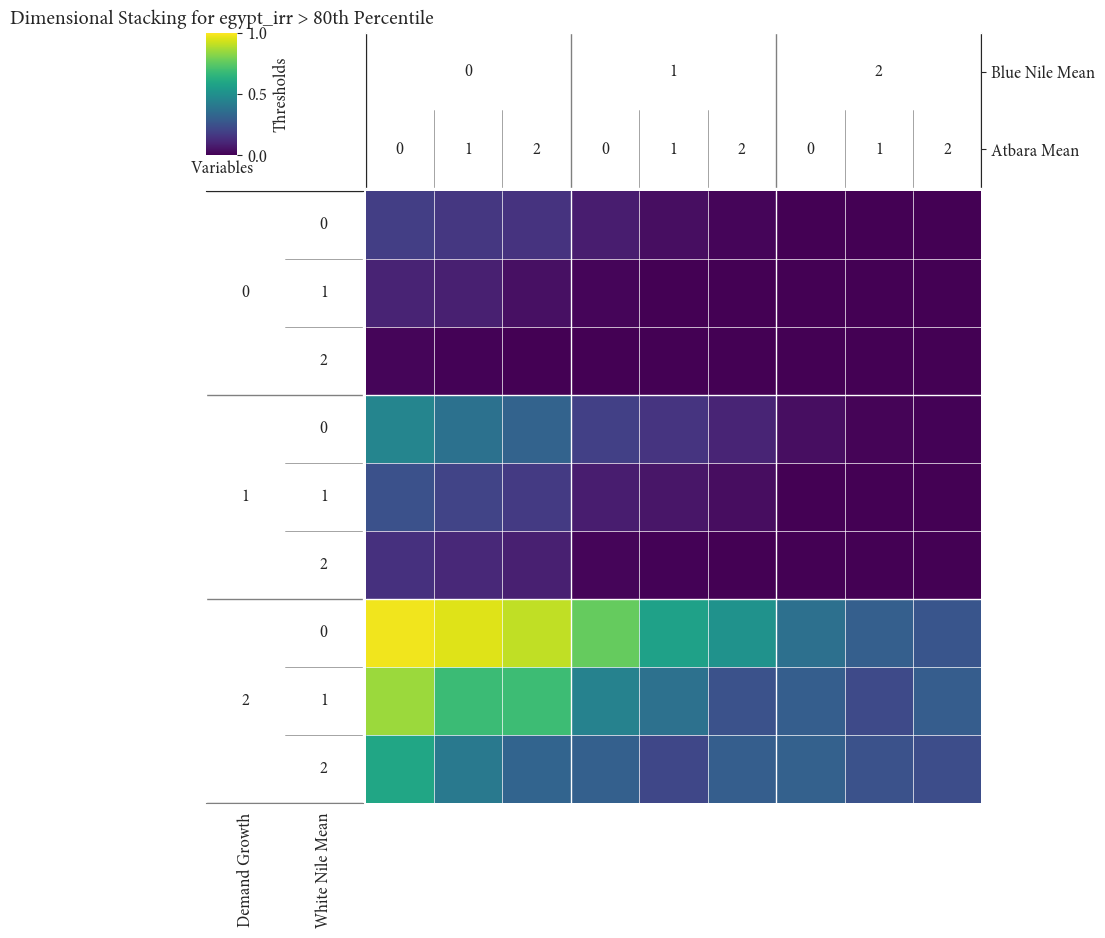

Smaller than 20th


<Figure size 1200x1200 with 0 Axes>

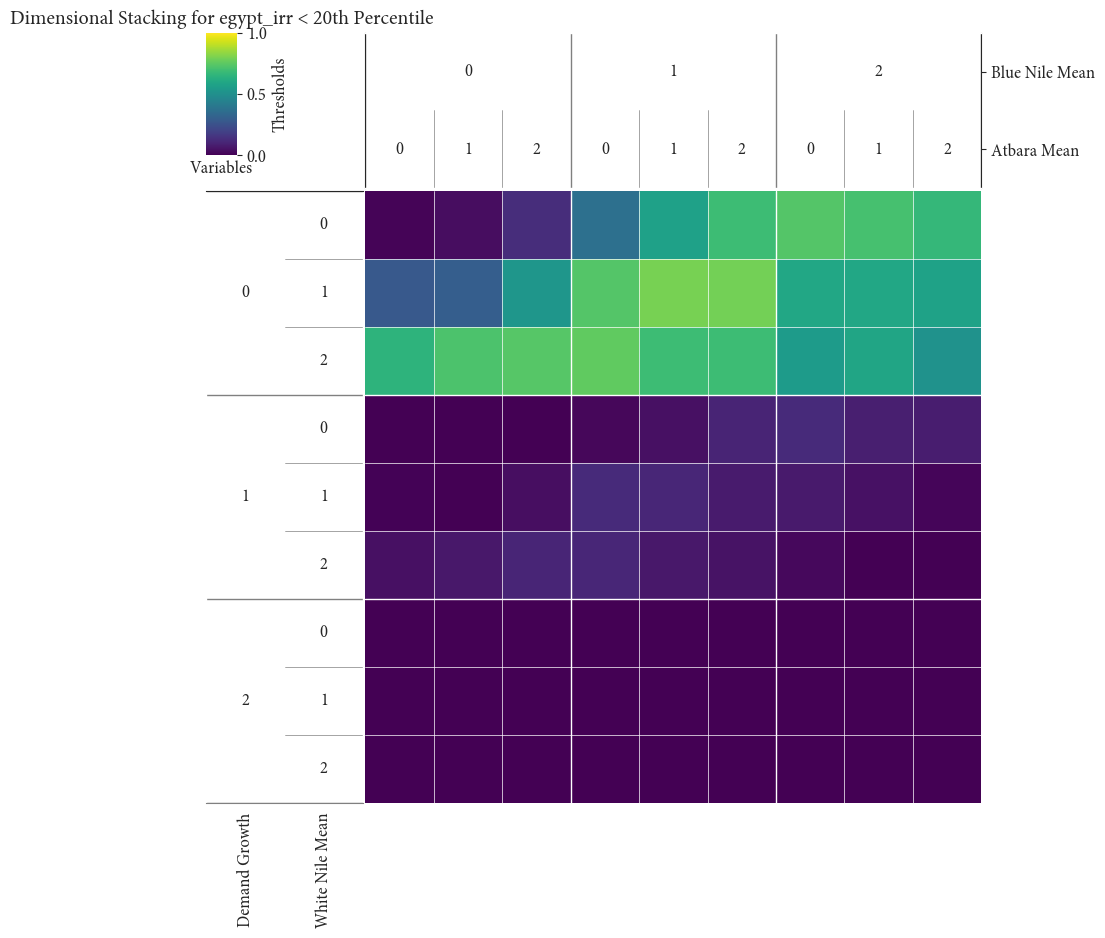

------------
egypt_low_had
------------

Bigger than 80th


<Figure size 1200x1200 with 0 Axes>

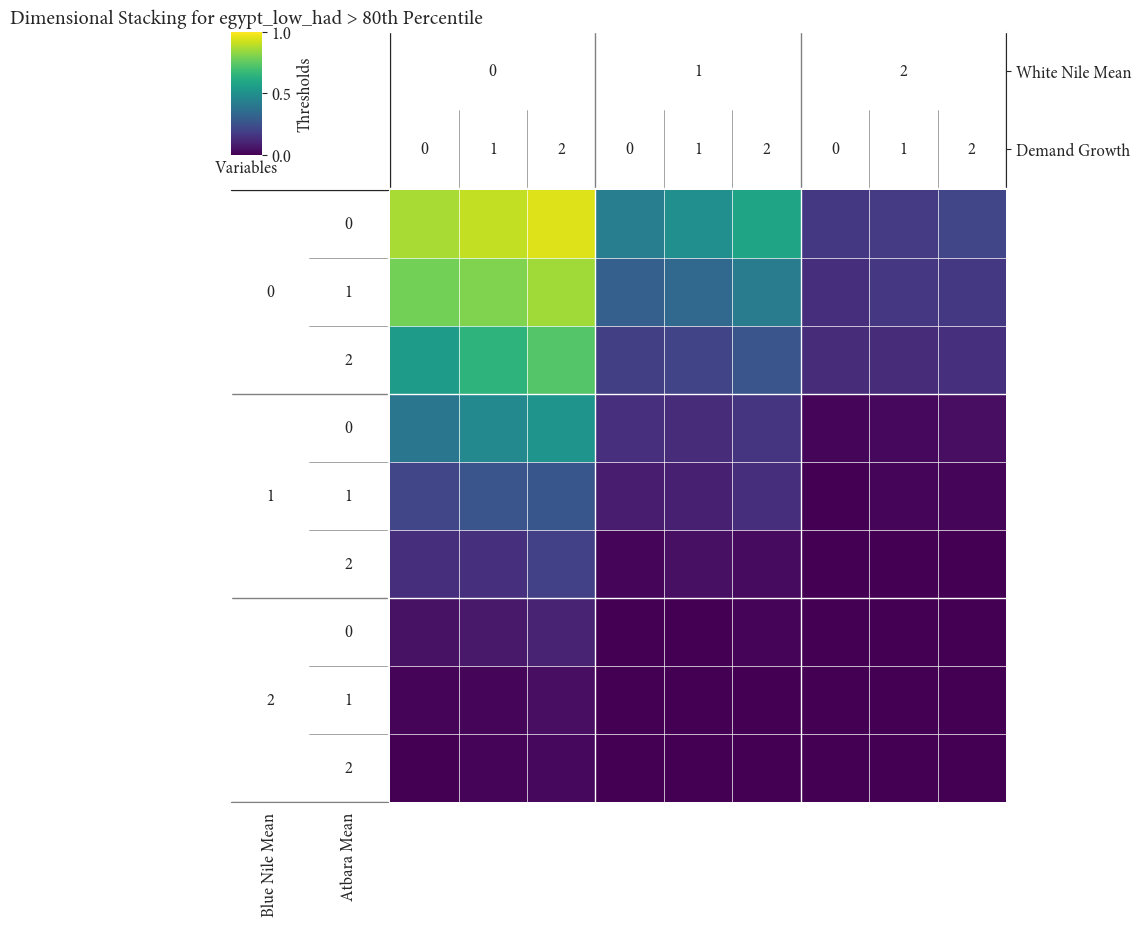

Smaller than 20th


<Figure size 1200x1200 with 0 Axes>

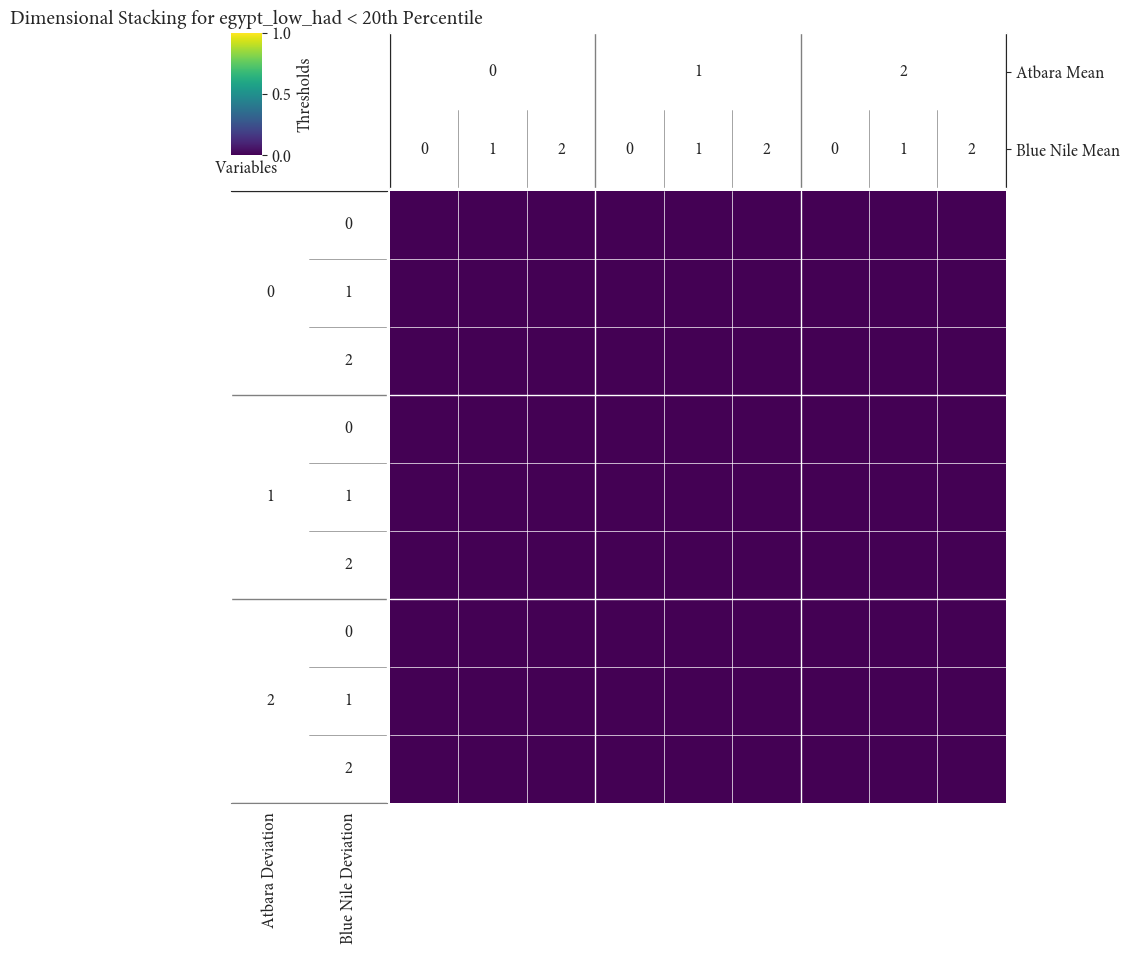

------------
sudan_irr
------------

Bigger than 80th


<Figure size 1200x1200 with 0 Axes>

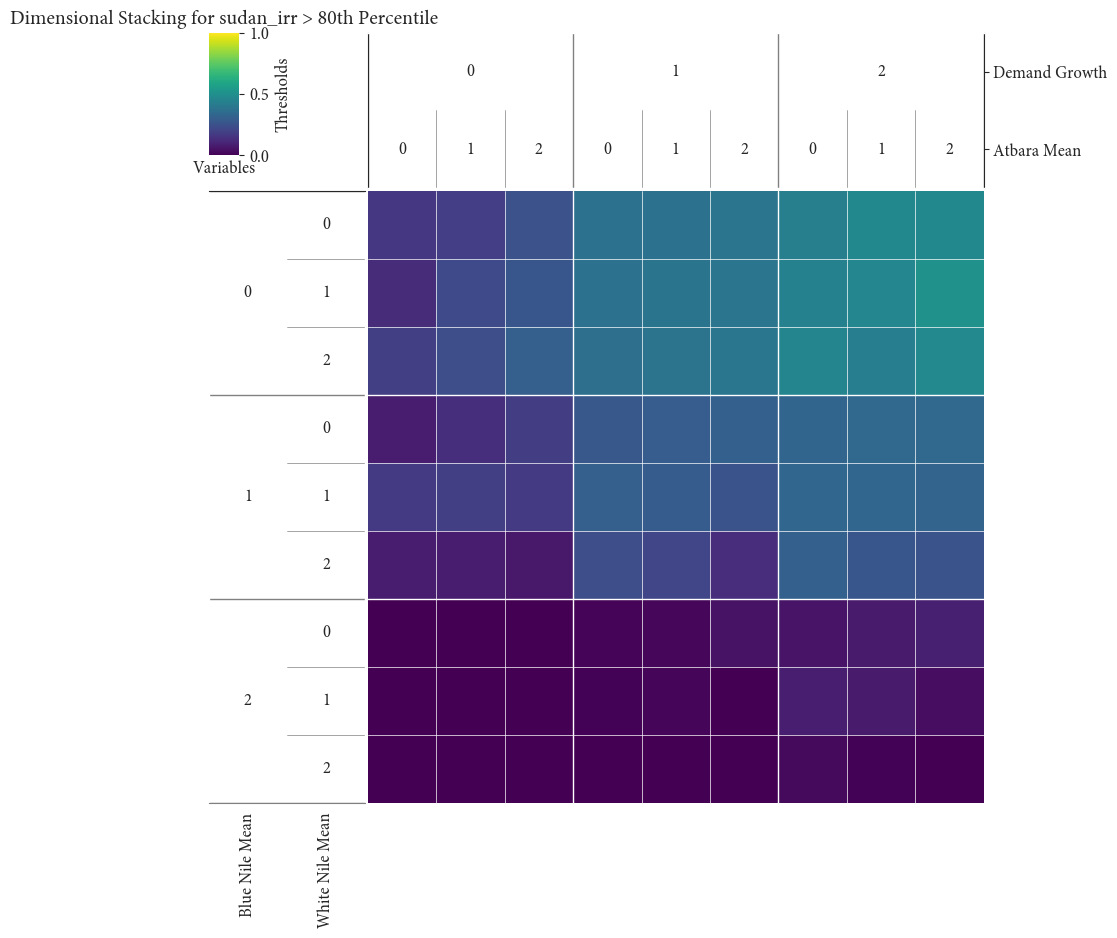

Smaller than 20th


<Figure size 1200x1200 with 0 Axes>

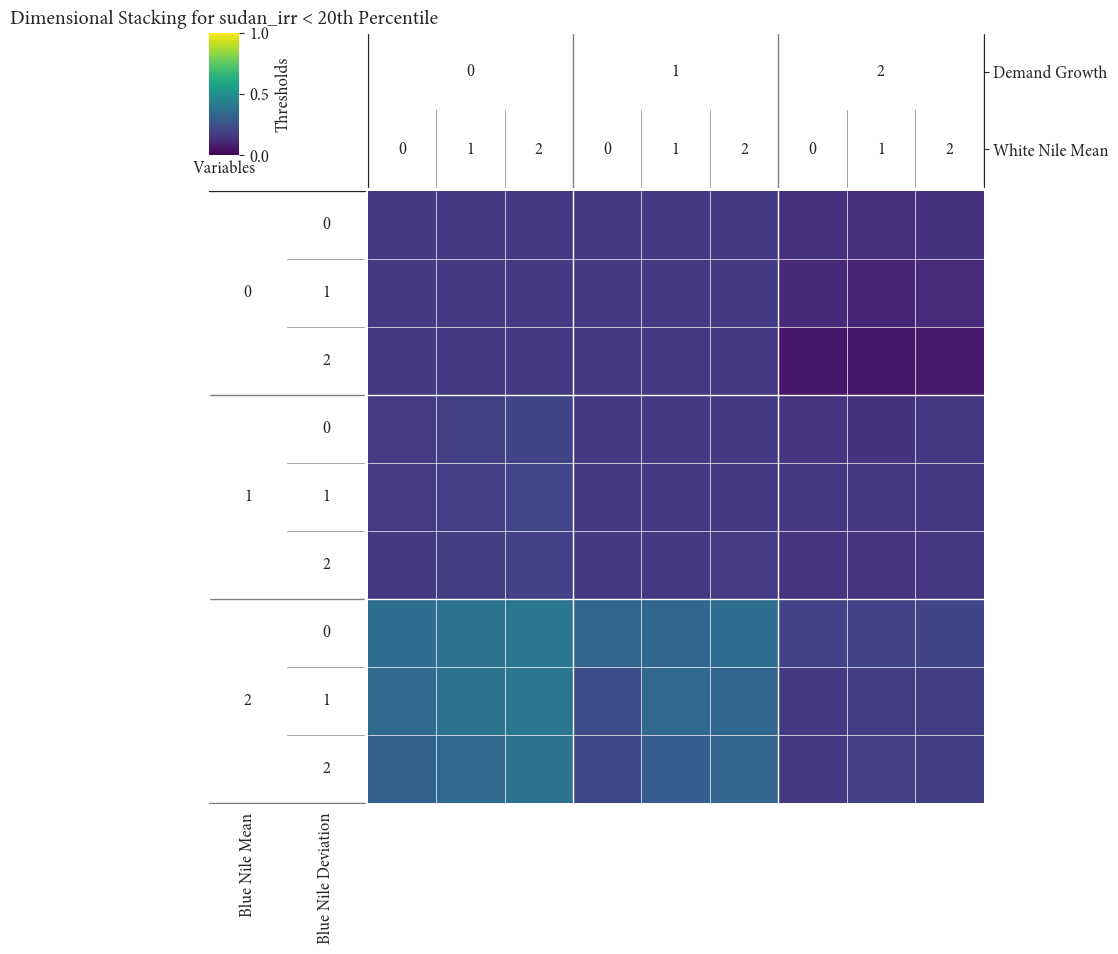

------------
ethiopia_hydro
------------

Bigger than 80th


<Figure size 1200x1200 with 0 Axes>

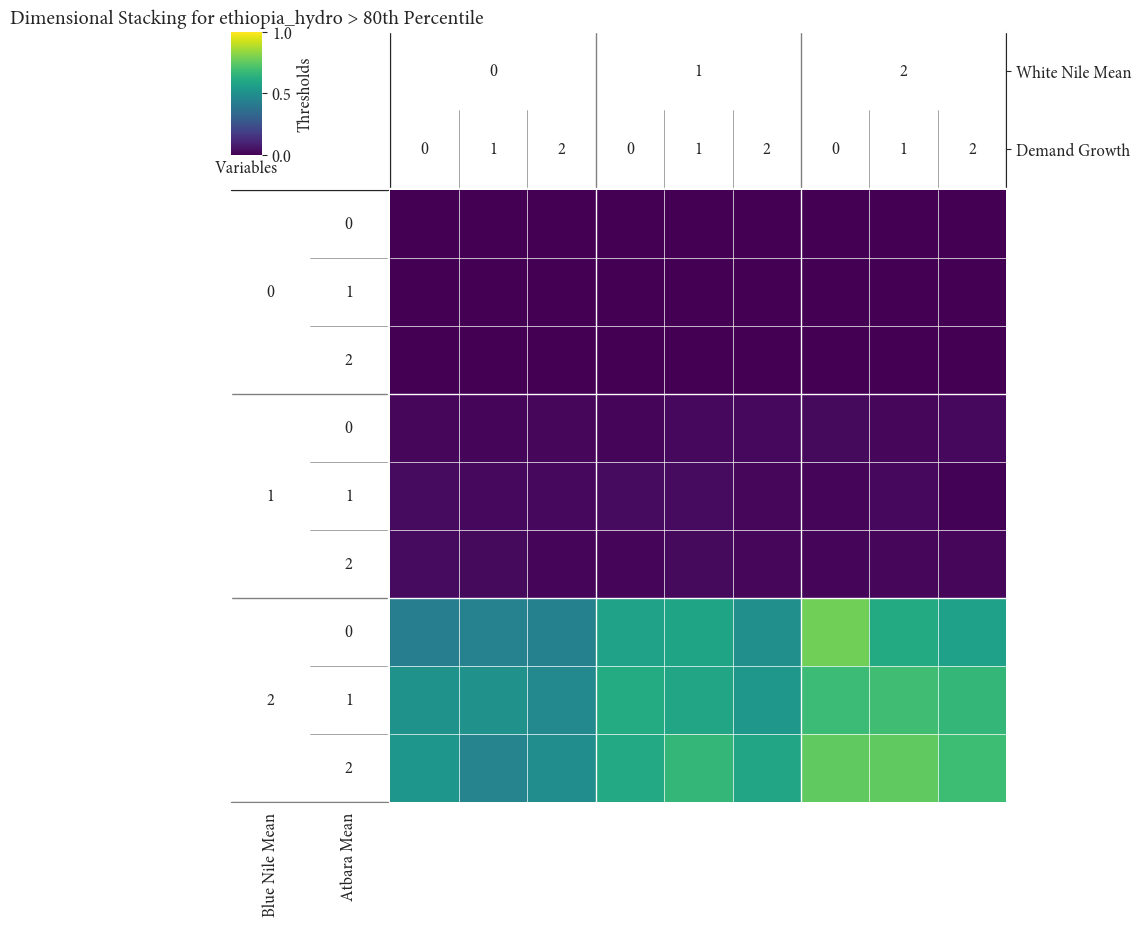

Smaller than 20th


<Figure size 1200x1200 with 0 Axes>

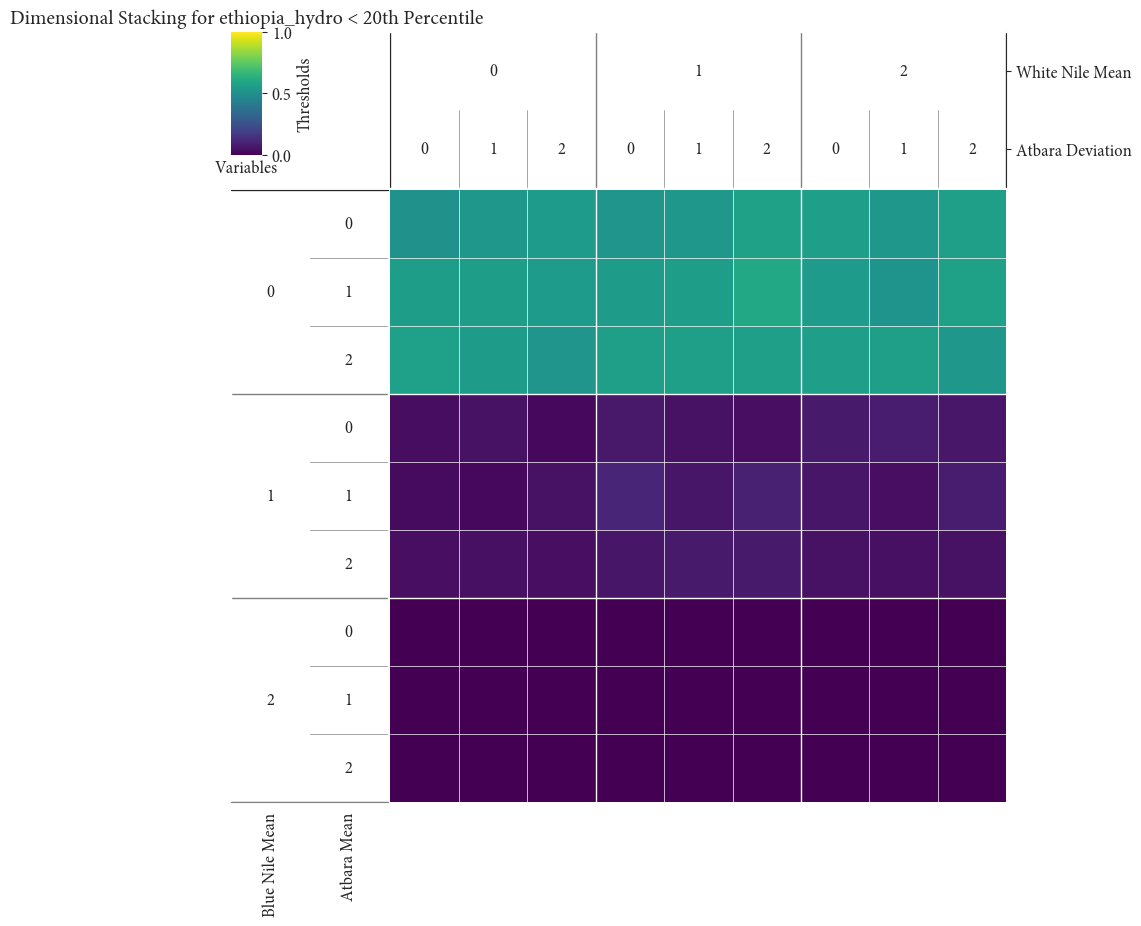

In [12]:
x = experiments.iloc[:, :7].copy()
x.columns = [
    "Atbara Deviation",
    "Atbara Mean",
    "Blue Nile Deviation",
    "Blue Nile Mean",
    "White Nile Deviation",
    "White Nile Mean",
    "Demand Growth",
]

for i, obj in enumerate(outcomes.iloc[:, :-2].columns):
    print("------------")
    print(obj)
    print("------------\n")
    
    print("Bigger than 80th")
    y = outcomes[obj] > np.percentile(outcomes[obj], 80)
    plt.figure(figsize=(12, 12))
    dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3)
    plt.xlabel("Variables")
    plt.ylabel("Thresholds")
    plt.title(f"Dimensional Stacking for {obj} > 80th Percentile")
    plt.savefig(
        f"../plots/scenario_analysis/{obj}_bigger80_dimensional_stacking.svg",
        bbox_inches="tight",
    )
    plt.show()
    
    print("Smaller than 20th")
    y = outcomes[obj] < np.percentile(outcomes[obj], 20)
    plt.figure(figsize=(12, 12))
    dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3)
    plt.xlabel("Variables")
    plt.ylabel("Thresholds")
    plt.title(f"Dimensional Stacking for {obj} < 20th Percentile")
    plt.savefig(
        f"../plots/scenario_analysis/{obj}_smaller20_dimensional_stacking.svg",
        bbox_inches="tight",
    )
    plt.show()

------------
egypt_irr
------------

Bigger than 80th


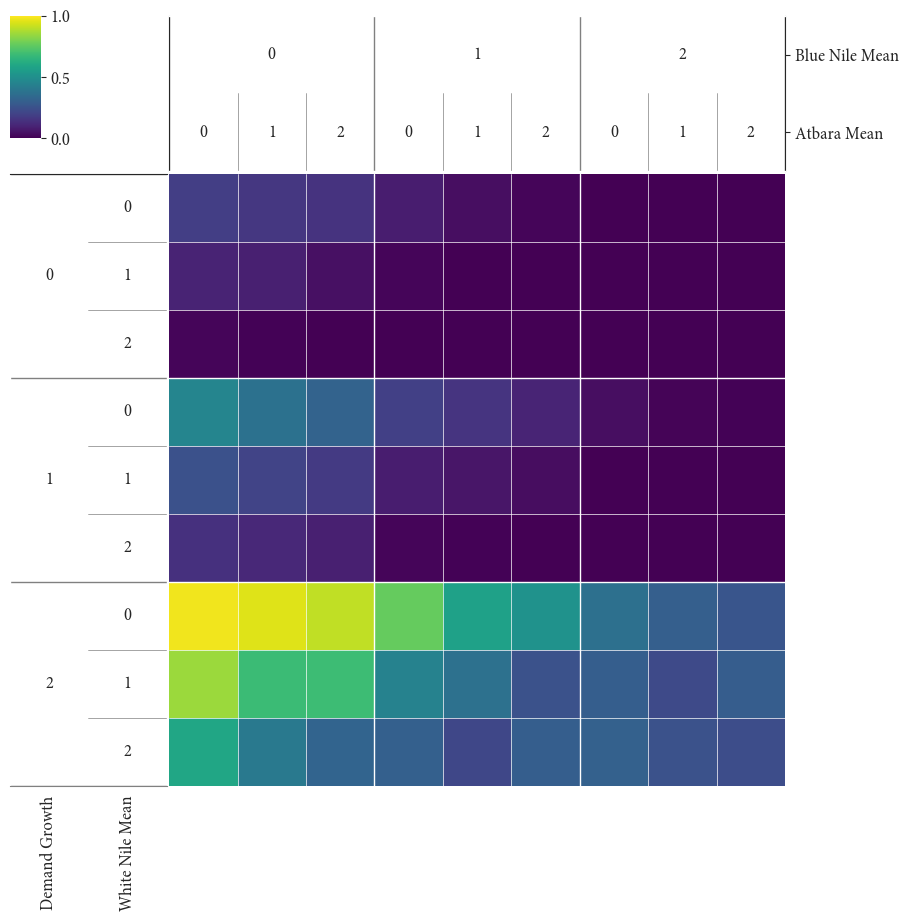

Smaller than 20th


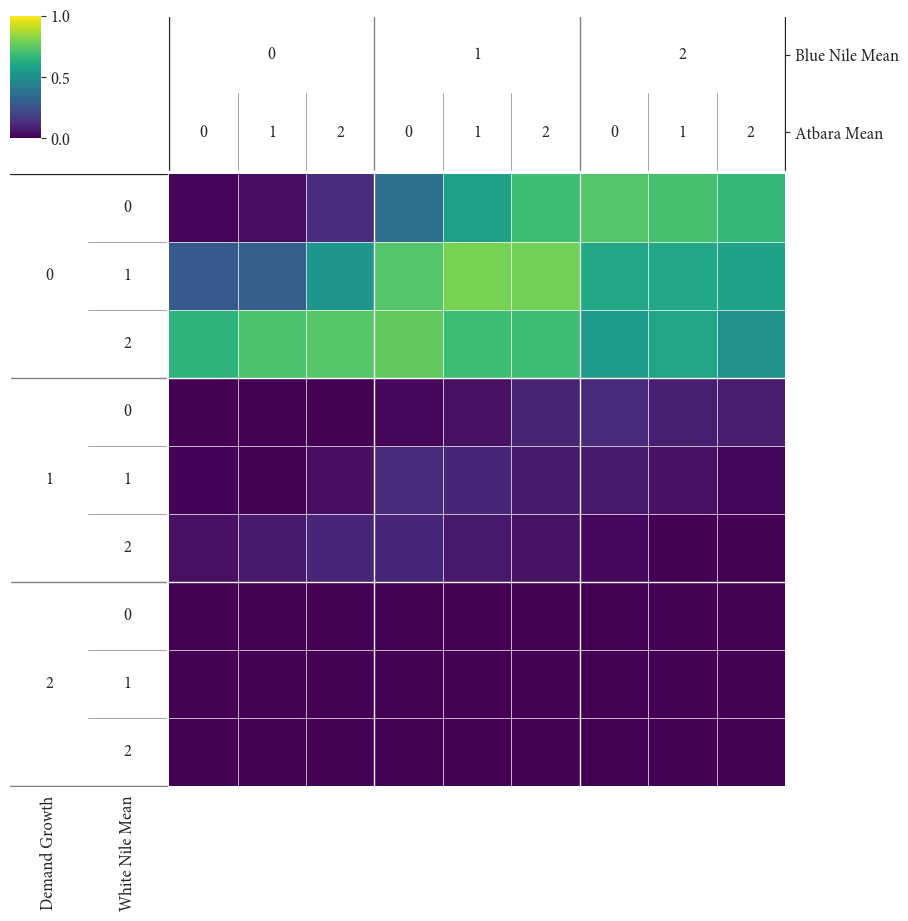

------------
egypt_low_had
------------

Bigger than 80th


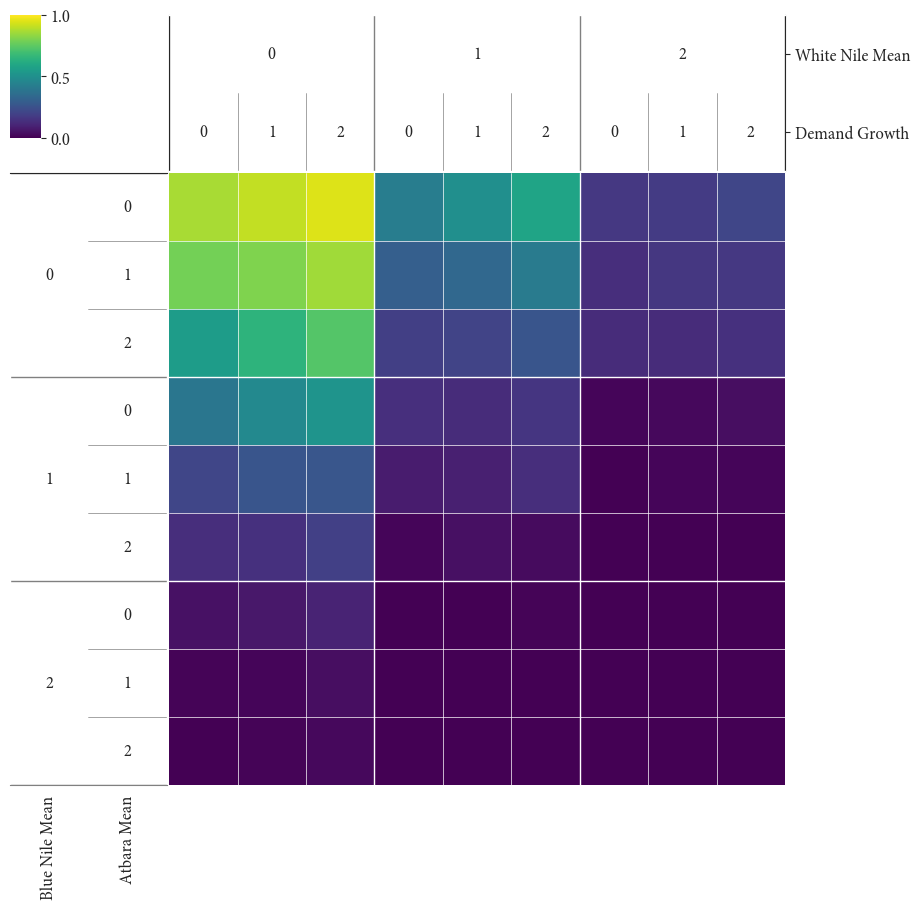

Smaller than 20th


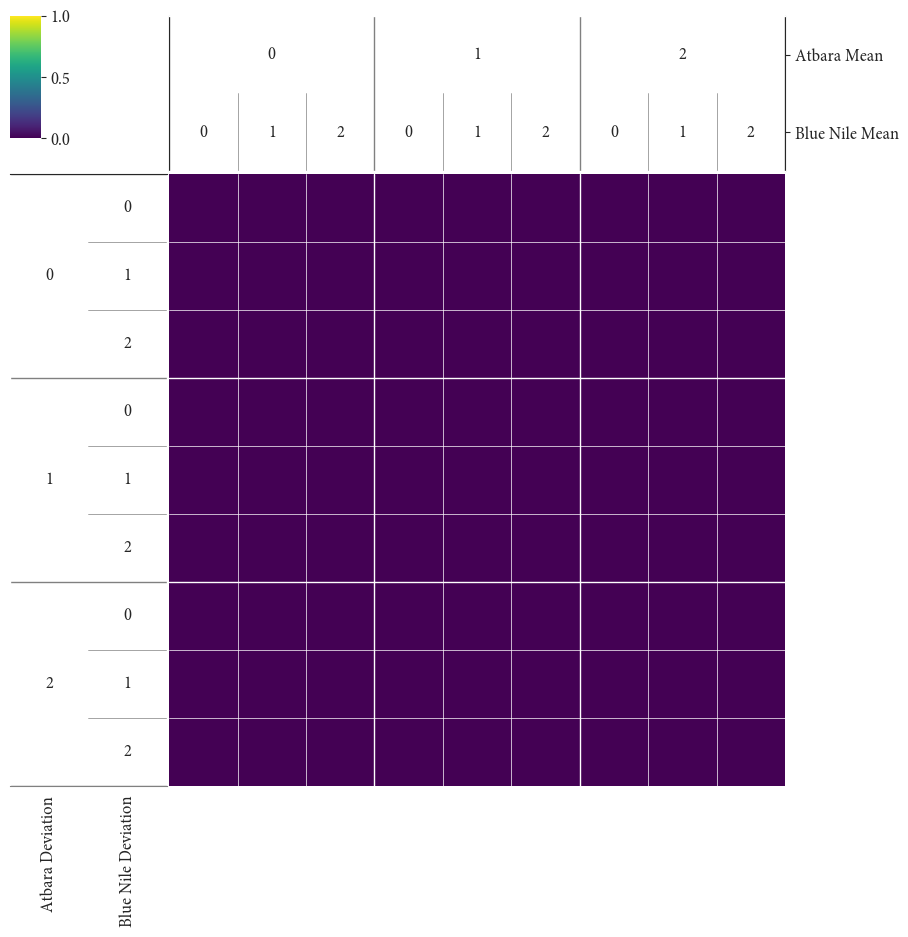

------------
sudan_irr
------------

Bigger than 80th


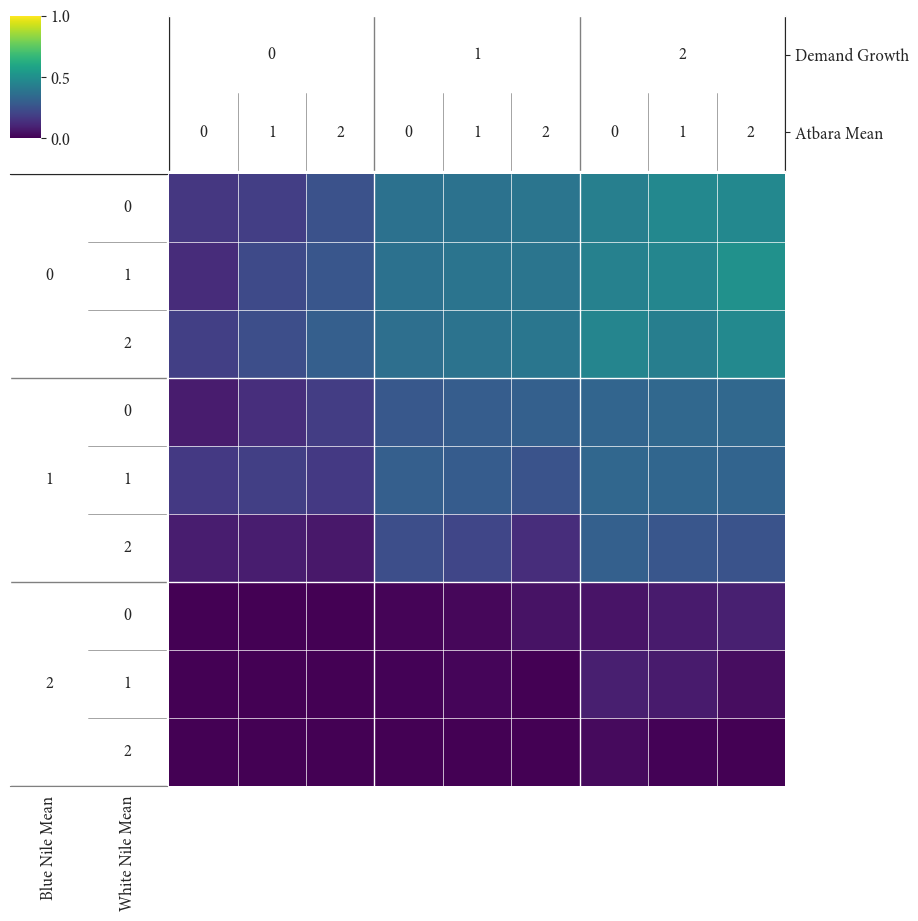

Smaller than 20th


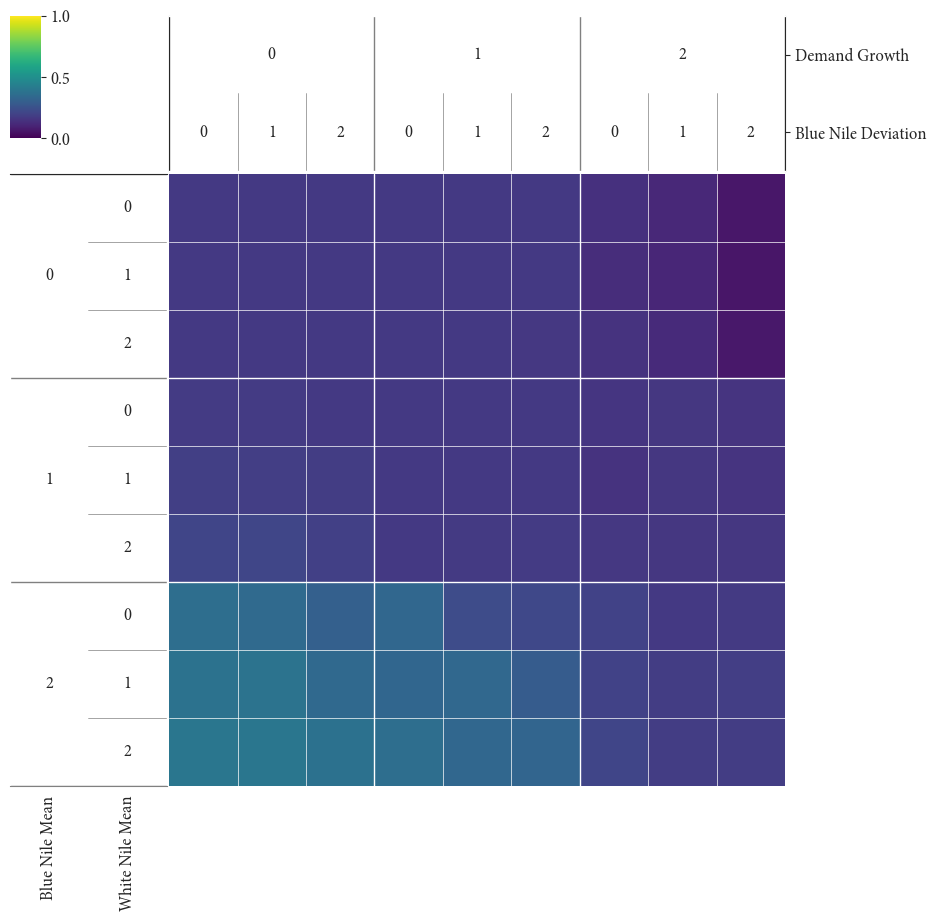

------------
ethiopia_hydro
------------

Bigger than 80th


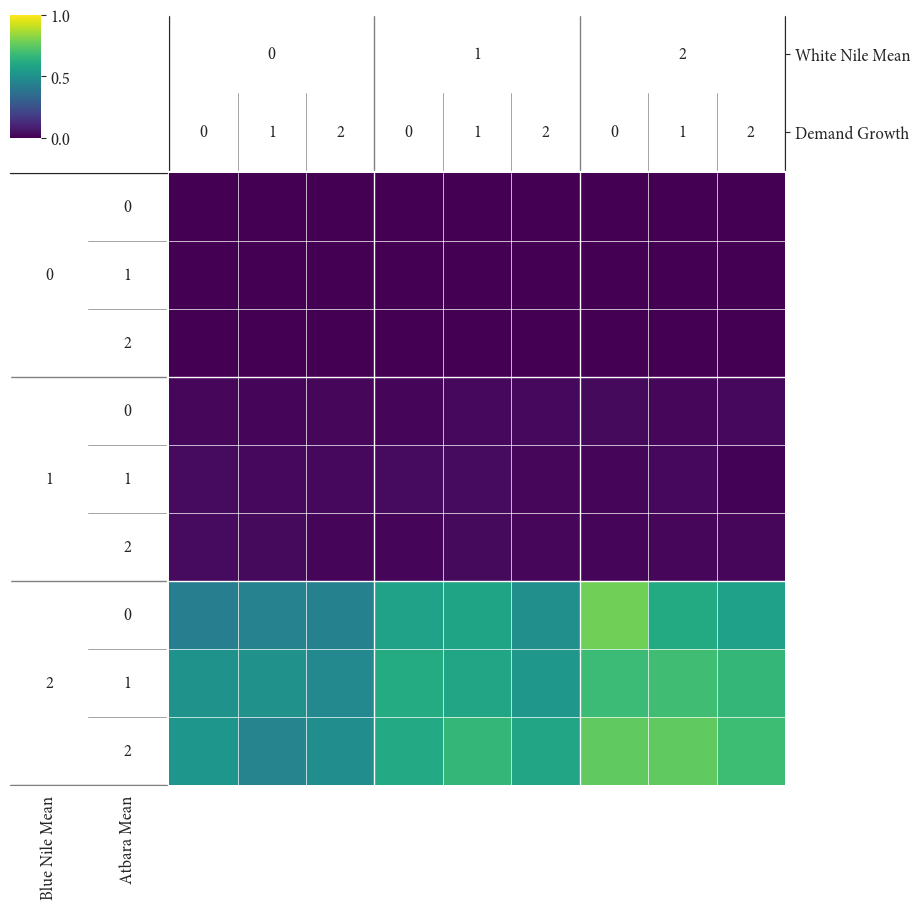

Smaller than 20th


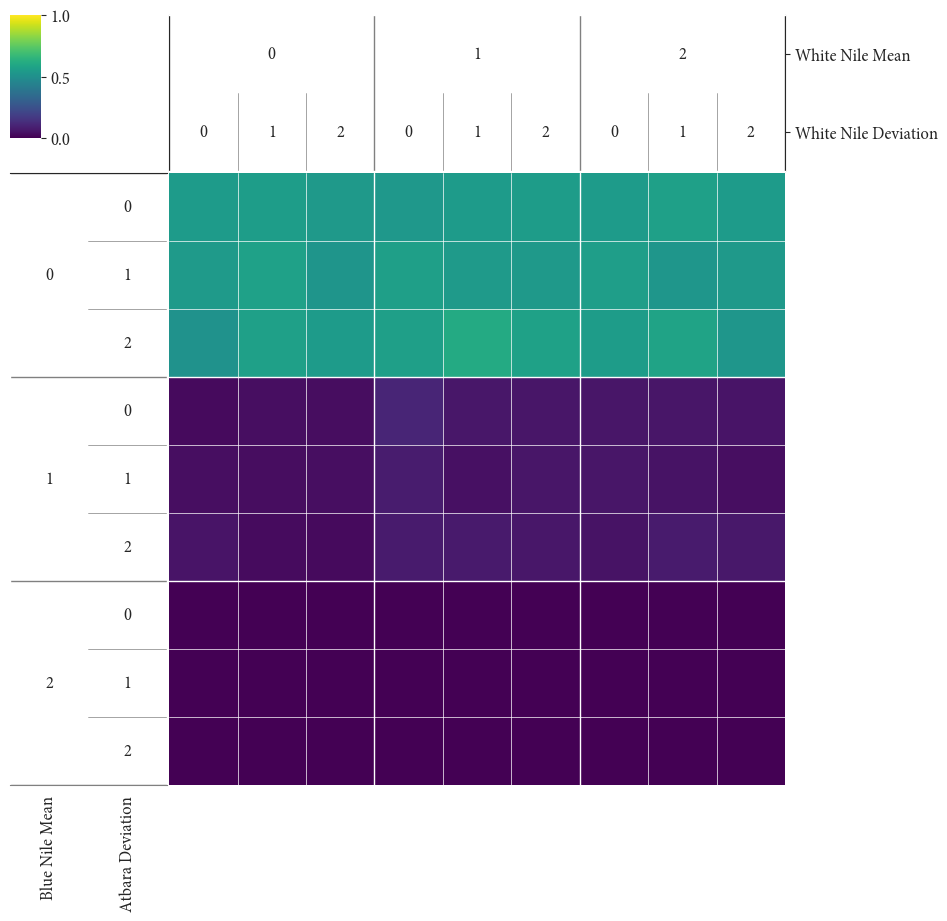

In [17]:
 #TODO: 1) Nicely rename axis labels. 2) Set-up .svg image saver code
# Let's see vulnerable and opportunity scenarios (</> than 20% best/worst for each objective):
x = experiments.iloc[:, :7].copy()
x.columns = [
    "Atbara Deviation",
    "Atbara Mean",
    "Blue Nile Deviation",
    "Blue Nile Mean",
    "White Nile Deviation",
    "White Nile Mean",
    "Demand Growth",
]

for i, obj in enumerate(outcomes.iloc[:, :-2].columns):
    print("------------")
    print(obj)
    print("------------\n")
    print("Bigger than 80th")
    y = outcomes[obj] > np.percentile(outcomes[obj], 80)
    dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3)
    plt.savefig(
        f"../plots/scenario_analysis/{obj}_bigger80_dimensional_stacking.svg",
        bbox_inches="tight",
    )
    plt.show()
    print("Smaller than 20th")
    y = outcomes[obj] < np.percentile(outcomes[obj], 20)
    dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3)
    plt.savefig(
        f"../plots/scenario_analysis/{obj}_smaller20_dimensional_stacking.svg",
        bbox_inches="tight",
    )
    plt.show()


Let's check the robustness of policies by calculating the maximum regret metric across scenarios:
Currently 10% to the best possible minus the absolute worst. **https://doi.org/10.1002/2017EF000649**.

90th Percentile Regret Scores

In [21]:
overall_regret = {}
max_regret = {}
max90_regret = {}
directions = ["min", "min", "min", "max"]

for i, outcome in enumerate(outcomes.columns[:4]):

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index="scenario", columns="policy")

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    if directions[i] == "min":
        outcome_regret = (data.min(axis=1)[:, np.newaxis] - data).abs()
    else:
        outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()

    overall_regret[outcome] = outcome_regret
    max_regret[outcome] = outcome_regret.max()
    max90_regret[outcome] = outcome_regret.quantile(
        0.9, axis=0, interpolation="nearest"
    )

regret_scores = pd.DataFrame.from_dict(max90_regret)
regret_scores

egypt_irr  egypt_low_had  sudan_irr  ethiopia_hydro
policy                                                                       
Best Egypt HAD             1.531978       0.000000   3.845014        3.955031
Best Egypt Irr.            0.992736       0.462500   3.759006        4.237890
Best Ethiopia Hydropower  11.865167       0.804167   1.562569        0.000000
Best Sudan Irr.            4.094031       0.508333   0.000000        3.205424
Compromise: Absolute       2.597938       0.233333   2.354386        1.319490
Compromise: Percentile     3.226169       0.200000   1.562835        1.328673

In [22]:
import numpy as np
import pandas as pd

overall_regret = {}
max_regret = {}
max90_regret = {}

# Assuming outcomes DataFrame is defined
for outcome in outcomes.columns[:4]:
    data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
    data = data.pivot(index="scenario", columns="policy")
    data.columns = data.columns.get_level_values(1)

    # Calculate regret
    best_performance = data.max(axis=1)
    regret = best_performance[:, np.newaxis] - data
    regret = regret.abs()
    
    overall_regret[outcome] = regret
    max_regret[outcome] = regret.max()
    max90_regret[outcome] = regret.quantile(0.9, axis=0)

regret_scores = pd.DataFrame.from_dict(max90_regret)

# Calculate rankings
rankings = regret_scores.rank(axis=0, method='min').astype(int)

# Style and display the DataFrames
styled_regret_scores = regret_scores.style.set_caption("90th Percentile Regret Scores").format("{:.2f}")
styled_rankings = rankings.style.set_caption("90th Percentile Regret Rankings").format("{:.0f}")

print("90th Percentile Regret Scores:")
display(styled_regret_scores)
print("\n90th Percentile Regret Rankings:")
display(styled_rankings)


90th Percentile Regret Scores:



90th Percentile Regret Rankings:


Count Robustness Metrics: Percentile Based Skewness

In [23]:
import numpy as np
import pandas as pd

# Assuming outcomes DataFrame is defined
percentile_skewness = {}
directions = ["min", "min", "min", "max"]

for i, outcome in enumerate(outcomes.columns[:4]):
    # Create a DataFrame with all the relevant information
    data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
    data = data.pivot(index="scenario", columns="policy")
    data.columns = data.columns.get_level_values(1)

    # Calculate percentiles
    p90 = data.quantile(0.9, axis=0)
    p10 = data.quantile(0.1, axis=0)
    p50 = data.median(axis=0)
    
    # Compute the numerator and denominator for skewness calculation
    numerator = (p90 + p10) / 2 - p50
    denominator = (p90 - p10) / 2
    skewness = numerator / denominator
    
    # Adjust skewness based on direction
    if directions[i] == "min":
        skewness = -skewness
    
    percentile_skewness[outcome] = skewness

percentile_skewness_df = pd.DataFrame.from_dict(percentile_skewness)

# Styling the DataFrame
cell = {
    "selector": "td",
    "props": [
        ("font-family", "Minion Pro"),
        ("font-size", "11pt"),
        ("text-align", "center"),
    ],
}
index_names = {
    "selector": ".index_name",
    "props": "font-family: Minion Pro; font-size: 10.5pt; background-color: black; text-align: center",
}
headers = {
    "selector": "th:not(.index_name)",
    "props": "font-family: Minion Pro; font-size: 10.5pt; background-color: black; text-align: center",
}

styled_skewness_df = percentile_skewness_df.style.background_gradient(cmap="Blues", axis=None).set_table_styles(
    [cell, index_names, headers]
)

styled_skewness_df


In [255]:
import numpy as np
import pandas as pd

# Assuming outcomes DataFrame is defined and populated with your data
percentile_skewness = {}
directions = ["min", "min", "min", "max"]

for i, outcome in enumerate(outcomes.columns[:4]):
    # Create a DataFrame with all the relevant information
    data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
    data = data.pivot(index="scenario", columns="policy")
    data.columns = data.columns.get_level_values(1)

    # Calculate percentiles
    p90 = data.quantile(0.9, axis=0)
    p10 = data.quantile(0.1, axis=0)
    p50 = data.median(axis=0)
    
    # Compute the numerator and denominator for skewness calculation
    numerator = (p90 + p10) / 2 - p50
    denominator = (p90 - p10) / 2
    skewness = numerator / denominator
    
    # Adjust skewness based on direction
    if directions[i] == "min":
        skewness = -skewness
    
    percentile_skewness[outcome] = skewness

# Create a DataFrame from the percentile_skewness dictionary
skewness_scores = pd.DataFrame.from_dict(percentile_skewness)

# Define a ranking function that considers the direction
def rank_skewness(scores, directions):
    rankings = pd.DataFrame(index=scores.index)
    for i, col in enumerate(scores.columns):  # Include all columns
        if directions[i] == "min":
            rankings[col] = scores[col].rank(method='min')
        else:
            rankings[col] = (-scores[col]).rank(method='min')
    return rankings

# Calculate the rankings for each outcome considering the direction
rankings = rank_skewness(skewness_scores, directions)

# Styling the DataFrames
styled_skewness_scores = skewness_scores.style.set_caption("Skewness Scores").format("{:.2f}")
styled_rankings = rankings.style.set_caption("Rankings").format("{:.0f}")

# Display the tables
print("Skewness Scores:")
display(styled_skewness_scores)
print("\nRankings:")
display(styled_rankings)


Skewness Scores:



Rankings:


Robustness Metrics: Mean Variance

In [257]:
import numpy as np
import pandas as pd

mean_variance = {}
directions = ["min", "min", "min", "max"]

# Assuming outcomes DataFrame is defined
for i, outcome in enumerate(outcomes.columns[:4]):
    data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
    data = data.pivot(index="scenario", columns="policy")
    data.columns = data.columns.get_level_values(1)

    mean = data.mean(axis=0)
    std_dev = data.std(axis=0)
    
    if directions[i] == "min":
        mv_metric = mean * std_dev  # For minimization
    else:
        mv_metric = mean / std_dev  # For maximization
    
    mean_variance[outcome] = mv_metric

# Create a DataFrame from the mean_variance dictionary
mean_variance_df = pd.DataFrame.from_dict(mean_variance)

# Define a ranking function that considers the direction
def rank_mean_variance(scores, directions):
    rankings = pd.DataFrame(index=scores.index)
    for i, col in enumerate(scores.columns):  # Include all columns
        if directions[i] == "min":
            rankings[col] = scores[col].rank(method='min')
        else:
            rankings[col] = (-scores[col]).rank(method='min')
    return rankings

# Calculate the rankings for each outcome considering the direction
rankings = rank_mean_variance(mean_variance_df, directions)

# Styling the DataFrames
styled_mean_variance_df = mean_variance_df.style.set_caption("Mean-Variance Robustness Metric").format("{:.2f}")
styled_rankings = rankings.style.set_caption("Rankings").format("{:.0f}")

# Display the tables
print("Mean-Variance Robustness Metric:")
display(styled_mean_variance_df)
print("\nRankings:")
display(styled_rankings)


Mean-Variance Robustness Metric:



Rankings:


Minimax Regret

In [258]:
minimax_regret = {}
directions = ["min", "min", "min", "max"]  # Adjust based on your objectives

# Assuming outcomes DataFrame is defined
for i, outcome in enumerate(outcomes.columns[:4]):
    data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
    data = data.pivot(index="scenario", columns="policy")
    data.columns = data.columns.get_level_values(1)

    if directions[i] == "min":
        regret = data.min(axis=1)[:, np.newaxis] - data
    else:
        regret = data.max(axis=1)[:, np.newaxis] - data

    regret = regret.abs()
    minimax_regret[outcome] = regret.max(axis=0)

minimax_regret_df = pd.DataFrame.from_dict(minimax_regret)

# Styling the DataFrame
cell = {
    "selector": "td",
    "props": [
        ("font-family", "Minion Pro"),
        ("font-size", "11pt"),
        ("text-align", "center"),
    ],
}
index_names = {
    "selector": ".index_name",
    "props": "font-family: Minion Pro; font-size: 10.5pt; background-color: black; text-align: center",
}
headers = {
    "selector": "th:not(.index_name)",
    "props": "font-family: Minion Pro; font-size: 10.5pt; background-color: black; text-align: center",
}

styled_minimax_regret_df = minimax_regret_df.style.background_gradient(cmap="Blues", axis=None).set_table_styles(
    [cell, index_names, headers]
)

styled_minimax_regret_df


In [259]:
import numpy as np
import pandas as pd

minimax_regret = {}

# Assuming outcomes DataFrame is defined
for outcome in outcomes.columns[:4]:
    data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
    data = data.pivot(index="scenario", columns="policy")
    data.columns = data.columns.get_level_values(1)

    # Calculate the best performance for each scenario
    best_performance = data.max(axis=1)

    # Calculate the regret
    regret = best_performance[:, np.newaxis] - data
    regret = regret.abs()

    # Calculate the maximum regret for each policy
    minimax_regret[outcome] = regret.max(axis=0)

# Create a DataFrame from the minimax_regret dictionary
minimax_regret_df = pd.DataFrame.from_dict(minimax_regret)

# Calculate rankings for individual outcomes directly
rankings = minimax_regret_df.rank(axis=0, method='min').astype(int)

# Style and display the DataFrames
styled_minimax_regret_df = minimax_regret_df.style.set_caption("Minimax Regret Metric").format("{:.2f}")
styled_rankings = rankings.style.set_caption("Minimax Regret Rankings").format("{:.0f}")

print("Minimax Regret Metric:")
display(styled_minimax_regret_df)
print("\nMinimax Regret Rankings:")
display(styled_rankings)


Minimax Regret Metric:



Minimax Regret Rankings:


Undesirable Variations

In [260]:
undesirable_variations = {}
directions = ["min", "min", "min", "max"]  # Adjust based on your objectives

# Assuming outcomes DataFrame is defined
scaler = MinMaxScaler()

for i, outcome in enumerate(outcomes.columns[:4]):
    data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
    data = data.pivot(index="scenario", columns="policy")
    data.columns = data.columns.get_level_values(1)

    # Normalize data
    normalized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

    median = normalized_data.median(axis=0)
    
    if directions[i] == "min":
        deviations = ((normalized_data - median) ** 2) * (normalized_data > median)
    else:
        deviations = ((normalized_data - median) ** 2) * (normalized_data < median)
    
    rms_deviations = np.sqrt(deviations.mean(axis=0))
    undesirable_variations[outcome] = rms_deviations

undesirable_variations_df = pd.DataFrame.from_dict(undesirable_variations)

# Styling the DataFrame
cell = {
    "selector": "td",
    "props": [
        ("font-family", "Minion Pro"),
        ("font-size", "11pt"),
        ("text-align", "center"),
    ],
}
index_names = {
    "selector": ".index_name",
    "props": "font-family: Minion Pro; font-size: 10.5pt; background-color: black; text-align: center",
}
headers = {
    "selector": "th:not(.index_name)",
    "props": "font-family: Minion Pro; font-size: 10.5pt; background-color: black; text-align: center",
}

styled_undesirable_variations_df = undesirable_variations_df.style.background_gradient(cmap="Blues", axis=None).set_table_styles(
    [cell, index_names, headers]
)

styled_undesirable_variations_df

In [261]:
import numpy as np
import pandas as pd

undesirable_variations = {}
directions = ["min", "min", "min", "max"]  # Adjust based on your objectives

# Assuming outcomes DataFrame is defined

for i, outcome in enumerate(outcomes.columns[:4]):
    data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
    data = data.pivot(index="scenario", columns="policy")
    data.columns = data.columns.get_level_values(1)

    median = data.median(axis=0)
    
    if directions[i] == "min":
        # Sum of squared deviations for values greater than the median
        deviations = ((data - median) ** 2) * (data > median)
    else:
        # Sum of squared deviations for values less than the median
        deviations = ((data - median) ** 2) * (data < median)
    
    sum_deviations = deviations.sum(axis=0)
    undesirable_variations[outcome] = sum_deviations

undesirable_variations_df = pd.DataFrame.from_dict(undesirable_variations)

# Calculate rankings for individual outcomes directly
rankings = undesirable_variations_df.rank(axis=0, method='min').astype(int)

# Styling the DataFrames
styled_undesirable_variations_df = undesirable_variations_df.style.set_caption("Undesirable Deviations Metric").format("{:.2f}")
styled_rankings = rankings.style.set_caption("Rankings").format("{:.0f}")

# Display the tables
print("Undesirable Deviations Metric:")
display(styled_undesirable_variations_df)
print("\nRankings:")
display(styled_rankings)


Undesirable Deviations Metric:



Rankings:


Agreement Percentage

In [263]:
import numpy as np
import pandas as pd

# Define functions for each metric
def percentile_based_skewness(outcomes, directions):
    percentile_skewness = {}
    for i, outcome in enumerate(outcomes.columns[:4]):
        data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
        data = data.pivot(index="scenario", columns="policy")
        data.columns = data.columns.get_level_values(1)
        p90 = data.quantile(0.9, axis=0)
        p10 = data.quantile(0.1, axis=0)
        p50 = data.median(axis=0)
        numerator = (p90 + p10) / 2 - p50
        denominator = (p90 - p10) / 2
        skewness = numerator / denominator
        if directions[i] == "min":
            skewness = -skewness
        percentile_skewness[outcome] = skewness
    skewness_scores = pd.DataFrame.from_dict(percentile_skewness)
    return skewness_scores.rank(axis=0, method='min').fillna(0).astype(int)

def mean_variance(outcomes, directions):
    mean_variance = {}
    for i, outcome in enumerate(outcomes.columns[:4]):
        data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
        data = data.pivot(index="scenario", columns="policy")
        data.columns = data.columns.get_level_values(1)
        mean = data.mean(axis=0)
        std_dev = data.std(axis=0)
        if directions[i] == "min":
            mv_metric = mean * std_dev
        else:
            mv_metric = mean / std_dev
        mean_variance[outcome] = mv_metric
    mean_variance_df = pd.DataFrame.from_dict(mean_variance)
    return mean_variance_df.rank(axis=0, method='min').fillna(0).astype(int)

def minimax_regret(outcomes):
    minimax_regret = {}
    for outcome in outcomes.columns[:4]:
        data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
        data = data.pivot(index="scenario", columns="policy")
        data.columns = data.columns.get_level_values(1)
        best_performance = data.max(axis=1)
        regret = best_performance[:, np.newaxis] - data
        regret = regret.abs()
        minimax_regret[outcome] = regret.max(axis=0)
    minimax_regret_df = pd.DataFrame.from_dict(minimax_regret)
    return minimax_regret_df.rank(axis=0, method='min').fillna(0).astype(int)

def undesirable_deviations(outcomes, directions):
    undesirable_variations = {}
    for i, outcome in enumerate(outcomes.columns[:4]):
        data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
        data = data.pivot(index="scenario", columns="policy")
        data.columns = data.columns.get_level_values(1)
        median = data.median(axis=0)
        if directions[i] == "min":
            deviations = ((data - median) ** 2) * (data > median)
        else:
            deviations = ((data - median) ** 2) * (data < median)
        sum_deviations = deviations.sum(axis=0)
        undesirable_variations[outcome] = sum_deviations
    undesirable_variations_df = pd.DataFrame.from_dict(undesirable_variations)
    return undesirable_variations_df.rank(axis=0, method='min').fillna(0).astype(int)

# Calculate the rankings
rankings_skewness = percentile_based_skewness(outcomes, directions)
rankings_mean_variance = mean_variance(outcomes, directions)
rankings_minimax_regret = minimax_regret(outcomes)
rankings_undesirable_deviations = undesirable_deviations(outcomes, directions)

# Define function to calculate agreement percentage
def calculate_agreement(rankings1, rankings2):
    agreements = []
    for policy1 in rankings1.index:
        for policy2 in rankings1.index:
            if policy1 != policy2:
                r1 = rankings1.loc[policy1] < rankings1.loc[policy2]
                r2 = rankings2.loc[policy1] < rankings2.loc[policy2]
                agreements.append((r1 == r2).mean())
    return np.mean(agreements)

# List of metrics
metrics = [
    ("Percentile-based skewness", rankings_skewness),
    ("Mean-Variance", rankings_mean_variance),
    ("Minimax regret", rankings_minimax_regret),
    ("Undesirable deviations", rankings_undesirable_deviations)
]

# Create an empty DataFrame for the agreement percentages
columns = ["Egypt: Irrigation", "Egypt: Low HAD", "Sudan: Irrigation", "Ethiopia: Hydropower"]
agreement_df = pd.DataFrame(index=pd.MultiIndex.from_product([["Percentile-based skewness", "Mean-Variance", "Minimax regret", "Undesirable deviations"], ["Percentile-based skewness", "Mean-Variance", "Minimax regret", "Undesirable deviations"]], names=['Metrics 1', 'Metrics 2']), columns=columns)

# Populate the DataFrame with agreement percentages
for (name1, ranking1) in metrics:
    for (name2, ranking2) in metrics:
        if name1 < name2:  # Ensure each pair is unique and ordered
            agreement_df.loc[(name1, name2)] = [
                calculate_agreement(ranking1["egypt_irr"], ranking2["egypt_irr"]),
                calculate_agreement(ranking1["egypt_low_had"], ranking2["egypt_low_had"]),
                calculate_agreement(ranking1["sudan_irr"], ranking2["sudan_irr"]),
                calculate_agreement(ranking1["ethiopia_hydro"], ranking2["ethiopia_hydro"])
            ]

# Convert the agreement values to percentages
agreement_df = agreement_df * 100

# Drop rows and columns with NaN values
agreement_df = agreement_df.dropna(how='all', axis=0).dropna(how='all', axis=1)

# Style the DataFrame
styled_agreement_df = agreement_df.style.background_gradient(cmap='RdYlGn').set_caption("% of the times that metrics agree on relative rankings").format("{:.2f}%")

# Display the styled DataFrame
styled_agreement_df


Ranking

In [156]:
# Let's see all objectives against one another, policies color-coded:
#sns.pairplot(
#     outcomes,
#     hue="policy",
#     vars=outcomes.keys(),
#     diag_kind="hist",
#     plot_kws={"s": 5},
#    palette="viridis",
#)
#plt.xticks(rotation=45)
#plt.savefig("../plots/scenario_analysis/policy_performances_pairplot.svg")
#plt.show()

**TODO: Color-code (and font type) this pandas dataframe in columns to show robustness!**

In [18]:
ordered_regret = regret_scores.loc[
    [
        "Best Egypt Irr.",
        "Best Egypt HAD",
        "Best Sudan Irr.",
        "Best Ethiopia Hydropower",
        "Compromise: Percentile",
        "Compromise: Absolute",
    ]
]
ordered_regret.columns = [
    "Egypt Irr. Deficit",
    "Egypt Low HAD",
    "Sudan Irr. Deficit",
    "Ethiopia Hydropower",
]

NameError: name 'regret_scores' is not defined

In [91]:
from matplotlib.colors import LinearSegmentedColormap

my_cmap = LinearSegmentedColormap.from_list(
    "rg", ["cornflowerblue", "w", "salmon"], N=256
)
styled_regret = ordered_regret.style.background_gradient(
    cmap=my_cmap, axis=0
).set_table_styles([cell, index_names, headers])
styled_regret

In [17]:
styled_regret.to_excel("../plots/tables/styled_regret.xlsx")

In [23]:
# ordered_regret = ordered_regret.drop(columns="sudan_90")
# importlib.reload(plotter)
# from plotter import parallel_plots_few_policies

# solution_names = [
#     "Best Egypt Irr.",
#     "Best Egypt HAD",
#     "Best Sudan Irr.",
#     "Best Ethiopia Hydropower",
#     "Compromise: Percentile Threshold",
#     "Compromise: Absolute Threshold",
# ]

# parallel_plots_few_policies(ordered_regret, solution_names=solution_names)

Now, my ambition is to identify at which regions of the uncertainty space, which policies perform superior and how much for each objective! For the "how much" part of this task, I will simply calculate the absolute improvement that the best policy in that particular scenario makes compared to the second best policy.

In [19]:
directions = ["min", "min", "min", "max"]
best_performer_df = pd.DataFrame(range(5000), columns=["Scenario"])
best_performer_df["Blue Nile Mean"] = experiments["blue_nile_mean_coef"][:5000]
best_performer_df["White Nile Mean"] = experiments["white_nile_mean_coef"][:5000]
best_performer_df["Demand Growth"] = experiments["yearly_demand_growth_rate"][:5000]
best_performer_df["Atbara Mean"] = experiments["atbara_mean_coef"][:5000]

performers = defaultdict(list)
improvements = defaultdict(list)
for scen in tqdm(range(5000)):
    scen_df = outcomes.loc[outcomes.scenario == scen].copy()
    for i, obj in enumerate(outcomes.iloc[:, :-2].columns):
        best, second_best = scen_df.sort_values(
            by=[obj], ascending=(directions[i] == "min")
        ).iloc[0:2][obj]
        policy = list(scen_df.loc[scen_df[obj] == best, "policy"])[0]
        improvement = abs(best - second_best)
        performers[obj].append(policy)
        improvements[obj].append(improvement)

for obj in outcomes.iloc[:, :-2].columns:
    best_performer_df[obj] = performers[obj]
    best_performer_df[f"{obj}_improvement"] = improvements[obj]

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:25<00:00, 192.64it/s]


In [20]:
best_performer_df

Scenario  Blue Nile Mean  White Nile Mean  Demand Growth  Atbara Mean  \
0            0            0.98             0.81           0.02         0.86   
1            1            1.22             0.90           0.02         1.07   
2            2            0.77             1.04           0.03         1.05   
3            3            0.91             0.99           0.02         0.76   
4            4            0.91             0.82           0.03         0.83   
...        ...             ...              ...            ...          ...   
4995      4995            1.07             1.18           0.03         0.86   
4996      4996            1.13             0.94           0.01         1.11   
4997      4997            1.10             1.09           0.03         0.76   
4998      4998            1.23             0.85           0.02         1.12   
4999      4999            0.98             1.19           0.01         0.84   

            egypt_irr  egypt_irr_improvement    egypt_low_had  \
0      Best Egypt HAD                   0.93   Best Egypt HAD   
1     Best Egypt Irr.                   0.52  Best Egypt Irr.   
2      Best Egypt HAD                   1.00   Best Egypt HAD   
3      Best Egypt HAD                   0.69   Best Egypt HAD   
4      Best Egypt HAD                   0.40   Best Egypt HAD   
...               ...                    ...              ...   
4995  Best Egypt Irr.                   1.58  Best Egypt Irr.   
4996  Best Egypt Irr.                   0.21  Best Egypt Irr.   
4997  Best Egypt Irr.                   1.80  Best Egypt Irr.   
4998  Best Egypt Irr.                   0.75  Best Egypt Irr.   
4999  Best Egypt Irr.                   0.56  Best Egypt Irr.   

      egypt_low_had_improvement        sudan_irr  sudan_irr_improvement  \
0                          0.01  Best Sudan Irr.                   0.24   
1                          0.00  Best Sudan Irr.                   0.11   
2                          0.00  Best Sudan Irr.                   2.07   
3                          0.04  Best Sudan Irr.                   0.59   
4                          0.01  Best Sudan Irr.                   0.81   
...                         ...              ...                    ...   
4995                       0.00  Best Sudan Irr.                   0.13   
4996                       0.00  Best Sudan Irr.                   0.10   
4997                       0.00  Best Sudan Irr.                   0.09   
4998                       0.00  Best Sudan Irr.                   0.12   
4999                       0.00  Best Sudan Irr.                   0.22   

                ethiopia_hydro  ethiopia_hydro_improvement  
0     Best Ethiopia Hydropower                        1.16  
1     Best Ethiopia Hydropower                        0.81  
2     Best Ethiopia Hydropower                        1.21  
3     Best Ethiopia Hydropower                        1.15  
4     Best Ethiopia Hydropower                        1.16  
...                        ...                         ...  
4995  Best Ethiopia Hydropower                        1.05  
4996  Best Ethiopia Hydropower                        0.91  
4997  Best Ethiopia Hydropower                        1.15  
4998  Best Ethiopia Hydropower                        0.82  
4999  Best Ethiopia Hydropower                        1.13  

[5000 rows x 13 columns]

------------
egypt_irr
------------



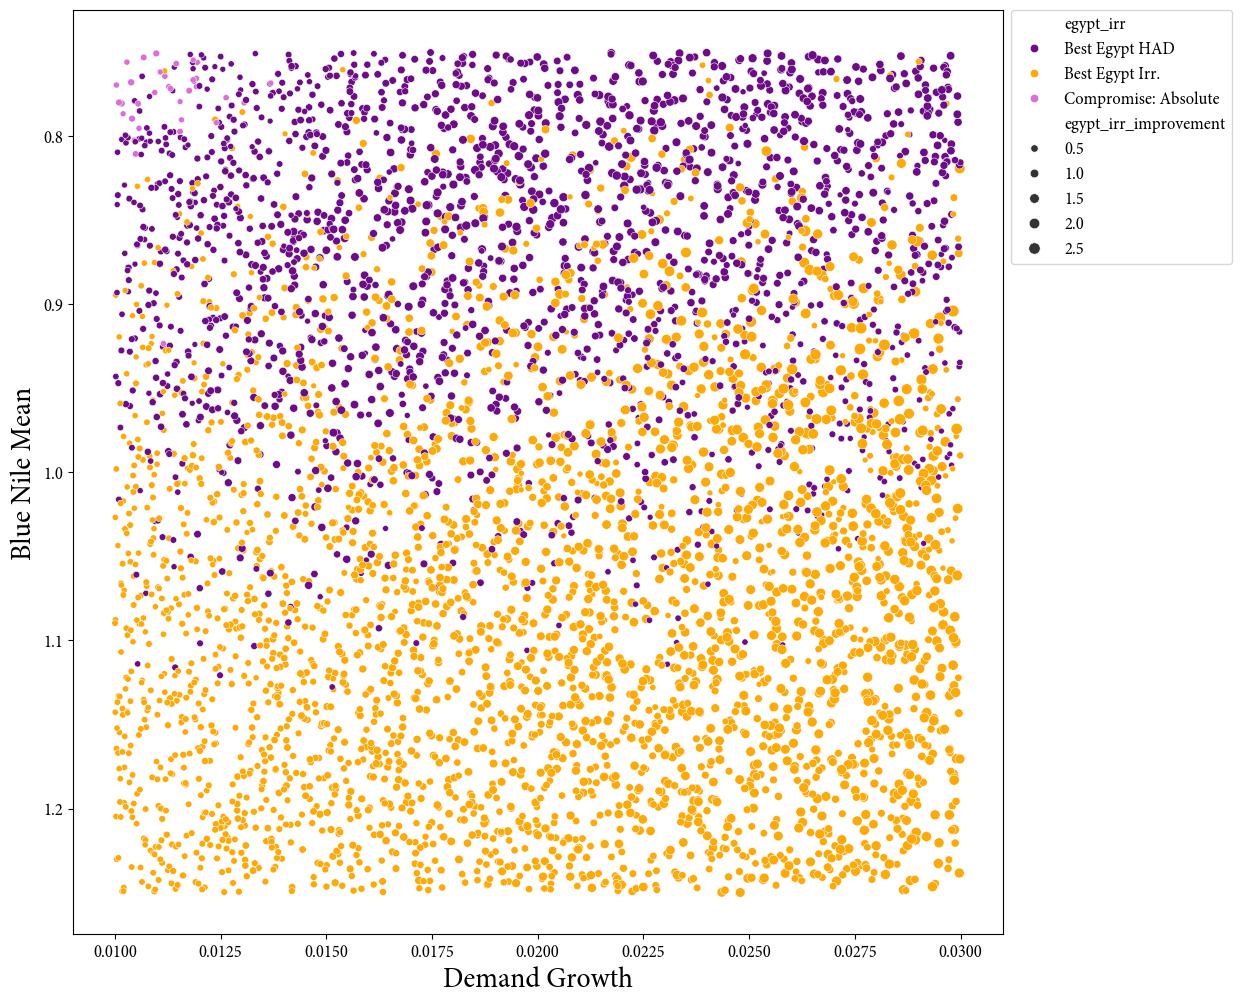

------------
egypt_low_had
------------



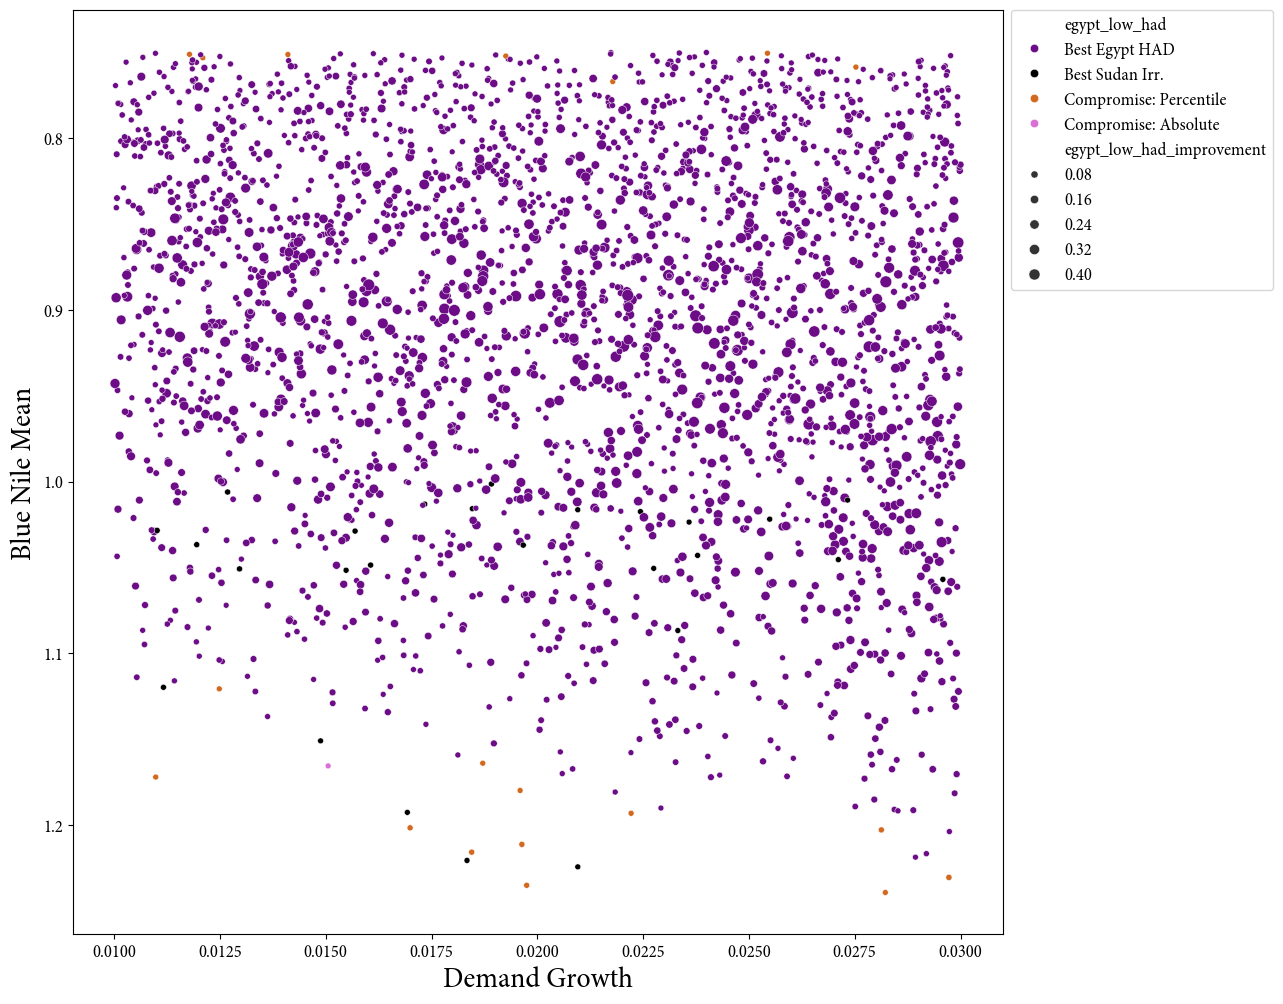

------------
sudan_irr
------------



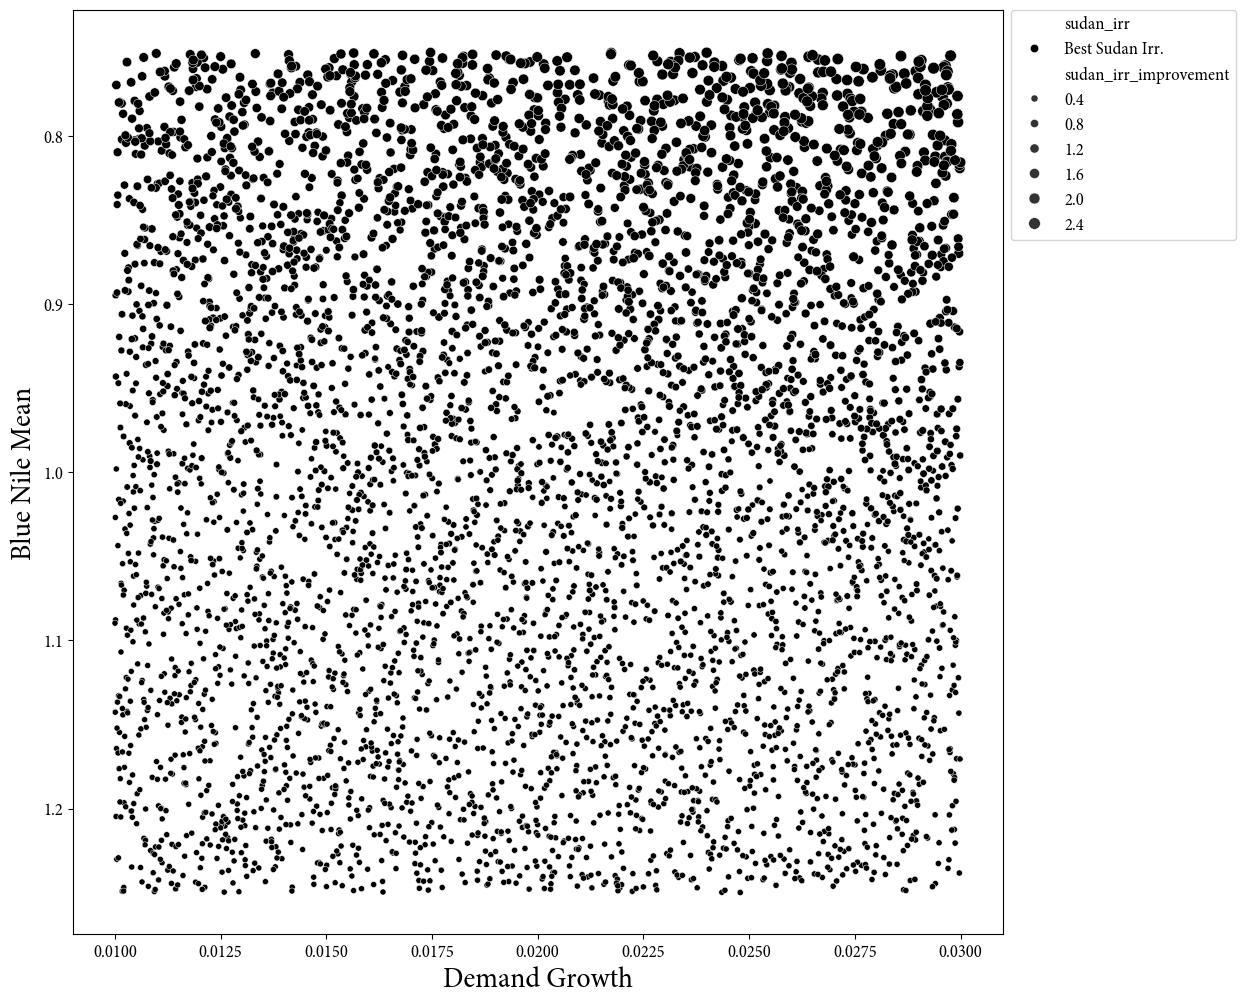

------------
ethiopia_hydro
------------



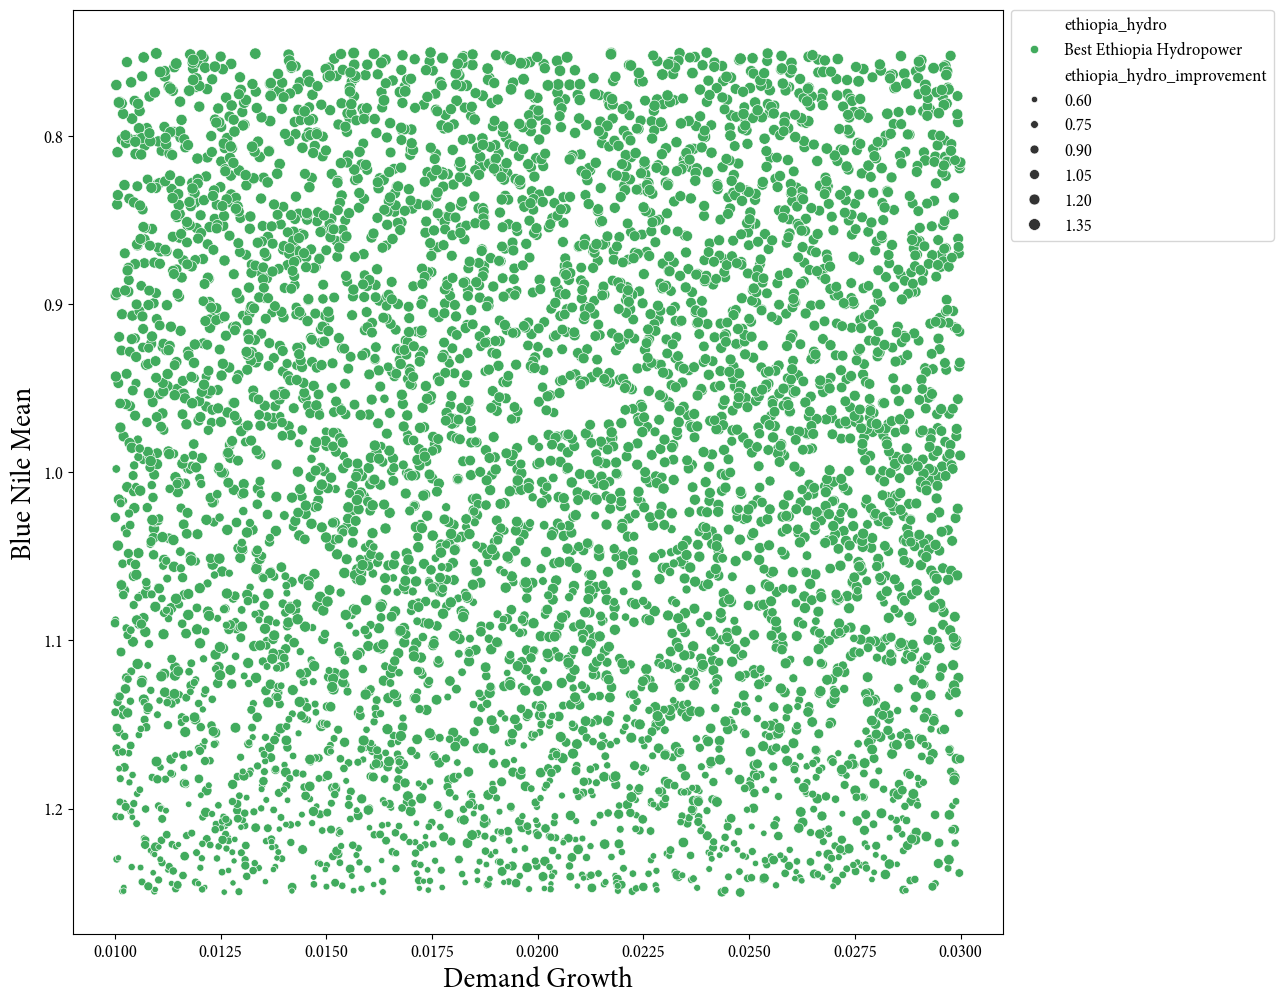

In [21]:
policy_colors = {
    "Best Egypt 90$^{th}$": "#0195fb",
    "Best Egypt HAD": "#6C0C86",
    "Compromise: Absolute": "orchid",
    "Best Ethiopia Hydropower": "#41ab5d",
    "Best Egypt Irr.": "#fdaa09",
    "Best Sudan Irr.": "#000000",
    "Compromise: Percentile": "chocolate",
}
for obj in outcomes.iloc[:, :-2].columns:
    print("------------")
    print(obj)
    print("------------\n")
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.scatterplot(
        data=best_performer_df[best_performer_df[f"{obj}_improvement"] > 0],
        x="Demand Growth",
        y="Blue Nile Mean",
        hue=obj,
        palette=policy_colors,
        size=f"{obj}_improvement",
        ax=ax,
    )
    ax.invert_yaxis()
    ax.legend(bbox_to_anchor=(1, 1.01))
    ax.yaxis.label.set_size(20)
    ax.xaxis.label.set_size(20)
    plt.savefig(
        f"../plots/scenario_analysis/{obj}_two_uncertainty_best_performer.svg",
        bbox_inches="tight",
    )
    plt.show()

In [23]:
from ema_workbench.analysis.dimensional_stacking import (
    _prepare_experiments,
    discretize,
    plot_pivot_table,
    dim_ratios,
    plot_index,
    plot_line,
    plot_category,
)

# Use the discretize function from dimensional stacking code: Basically dividing the critical uncertainties into the specified number of bins:
best_performer_df.iloc[:, 1:5] = discretize(
    best_performer_df.iloc[:, 1:5], nbins=3, with_labels=False
)
best_performer_df

Scenario  Blue Nile Mean  White Nile Mean  Demand Growth  Atbara Mean  \
0            0               1                0              0            0   
1            1               2                0              0            1   
2            2               0                1              2            1   
3            3               0                1              1            0   
4            4               0                0              2            0   
...        ...             ...              ...            ...          ...   
4995      4995               1                2              2            0   
4996      4996               2                1              0            2   
4997      4997               2                2              2            0   
4998      4998               2                0              1            2   
4999      4999               1                2              0            0   

            egypt_irr  egypt_irr_improvement    egypt_low_had  \
0      Best Egypt HAD                   0.93   Best Egypt HAD   
1     Best Egypt Irr.                   0.52  Best Egypt Irr.   
2      Best Egypt HAD                   1.00   Best Egypt HAD   
3      Best Egypt HAD                   0.69   Best Egypt HAD   
4      Best Egypt HAD                   0.40   Best Egypt HAD   
...               ...                    ...              ...   
4995  Best Egypt Irr.                   1.58  Best Egypt Irr.   
4996  Best Egypt Irr.                   0.21  Best Egypt Irr.   
4997  Best Egypt Irr.                   1.80  Best Egypt Irr.   
4998  Best Egypt Irr.                   0.75  Best Egypt Irr.   
4999  Best Egypt Irr.                   0.56  Best Egypt Irr.   

      egypt_low_had_improvement        sudan_irr  sudan_irr_improvement  \
0                          0.01  Best Sudan Irr.                   0.24   
1                          0.00  Best Sudan Irr.                   0.11   
2                          0.00  Best Sudan Irr.                   2.07   
3                          0.04  Best Sudan Irr.                   0.59   
4                          0.01  Best Sudan Irr.                   0.81   
...                         ...              ...                    ...   
4995                       0.00  Best Sudan Irr.                   0.13   
4996                       0.00  Best Sudan Irr.                   0.10   
4997                       0.00  Best Sudan Irr.                   0.09   
4998                       0.00  Best Sudan Irr.                   0.12   
4999                       0.00  Best Sudan Irr.                   0.22   

                ethiopia_hydro  ethiopia_hydro_improvement  
0     Best Ethiopia Hydropower                        1.16  
1     Best Ethiopia Hydropower                        0.81  
2     Best Ethiopia Hydropower                        1.21  
3     Best Ethiopia Hydropower                        1.15  
4     Best Ethiopia Hydropower                        1.16  
...                        ...                         ...  
4995  Best Ethiopia Hydropower                        1.05  
4996  Best Ethiopia Hydropower                        0.91  
4997  Best Ethiopia Hydropower                        1.15  
4998  Best Ethiopia Hydropower                        0.82  
4999  Best Ethiopia Hydropower                        1.13  

[5000 rows x 13 columns]

Below are the definitions of two functions used for plotting the policy/improvement visual:

In [24]:
def my_scatter_plotter(policy_pvt, improvement_pvt, ax_plot):
    maximum_imp = improvement_pvt.max().max()
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    ax_plot.scatter(
                        (3 * k + l + 0.5),
                        (3 * i + j + 0.5),
                        s=(500 / maximum_imp) * improvement_pvt.loc[(i, j), (k, l)],
                        c=policy_colors[policy_pvt.loc[(i, j), (k, l)]],
                    )
    # ax_plot.axis("off")

    # set the tick labels
    ax_plot.set_xticks([])
    ax_plot.set_yticks([])
    ax_plot.invert_yaxis()
    ax_plot.hlines([0, 1, 2, 4, 5, 7, 8, 9], 0, 9, colors="grey")
    ax_plot.hlines([3, 6], 0, 9, linewidths=3, colors="grey")
    ax_plot.vlines([0, 1, 2, 4, 5, 7, 8, 9], 0, 9, colors="grey")
    ax_plot.vlines([3, 6], 0, 9, linewidths=3, colors="grey")

    return ax_plot


def plot_policy_shift_scenarios(
    policy_pvt,
    improvement_pvt,
    unit_imp,
    plot_labels=True,
    plot_cats=True,
    figsize=(10, 10),
    cmap="viridis",
    **kwargs,
):
    """visualize a pivot table using colors
    Parameters
    ----------
    table : Pandas DataFrame
    plot_labels : bool, optional
                 if true, display uncertain factor names
    plot_cats : bool, optional
                 if true, display category labels for each uncertain factor
    fig_size : tuple of 2 ints, optional
               size of the figure to create
    cmap : matplotlib colormap name or object, optional
           default is viridis (requires matplotlib 1.5 or higher)
    kwargs : other keyword arguments
             All other keyword arguments are passed to ax.pcolormesh.
    Returns
    -------
    Figure
    """

    # with sns.axes_style("white"):
    fig = plt.figure(figsize=figsize)

    width_ratios = dim_ratios(figsize=figsize, axis=1)
    height_ratios = dim_ratios(figsize=figsize, axis=0)

    gs = mpl.gridspec.GridSpec(
        3,
        3,
        wspace=0.01,
        hspace=0.01,
        width_ratios=width_ratios,
        height_ratios=height_ratios,
    )

    ax_plot = fig.add_subplot(gs[2, 2])
    ax_rows = fig.add_subplot(gs[2, 0:2], facecolor="white")
    ax_cols = fig.add_subplot(gs[0:2, 2], facecolor="white")
    cax = fig.add_subplot(gs[0, 0])

    ax_plot = my_scatter_plotter(policy_pvt, improvement_pvt, ax_plot)

    # plot row labeling
    ax_rows.set_ylim(ax_plot.get_ylim())
    ax_rows.set_xlim(0, 1)
    plot_index(
        ax_rows,
        ax_plot,
        axis=1,
        index=improvement_pvt.index,
        plot_labels=plot_labels,
        plot_cats=plot_cats,
    )

    # plot column labeling
    ax_cols.set_xlim(ax_plot.get_xlim())
    ax_cols.set_ylim(0, 1)
    plot_index(
        ax_cols,
        ax_plot,
        axis=0,
        index=improvement_pvt.columns,
        plot_labels=plot_labels,
        plot_cats=plot_cats,
    )

    unique_policies = []
    for i in policy_pvt.values:
        unique_policies += list(i)

    unique_policies = list(set(unique_policies))

    legend_policies = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=pol,
            markerfacecolor=policy_colors[pol],
            markersize=10,
        )
        for pol in unique_policies
    ]
    maximum_imp = pvt_improvement.max().max()
    median_imp = pvt_improvement.median().median()

    legend_size = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=f"{round(maximum_imp,2)} {unit_imp}",
            markerfacecolor="k",
            markersize=math.sqrt(500),
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=f"{round(median_imp,2)} {unit_imp}",
            markerfacecolor="k",
            markersize=math.sqrt(500 * median_imp / maximum_imp),
        ),
    ]
    cax.axis("off")
    label_count = len(legend_policies + legend_size)
    lgnd = cax.legend(
        handles=legend_policies + legend_size,
        loc="upper center",
        bbox_to_anchor=(1.7, 0.1 + label_count * 0.2),
        frameon=False,
        fontsize="small",
        labelspacing=1.2,
    )
    lgnd.legendHandles[-2]._legmarker.set_markersize(math.sqrt(500))
    lgnd.legendHandles[-1]._legmarker.set_markersize(
        math.sqrt(500 * median_imp / maximum_imp)
    )

    return fig

0it [00:00, ?it/s]

------------
egypt_irr
------------



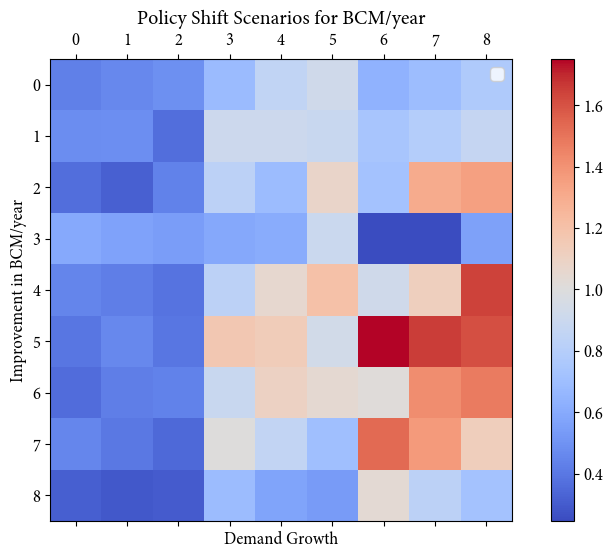

1it [00:05,  5.76s/it]

------------
egypt_low_had
------------



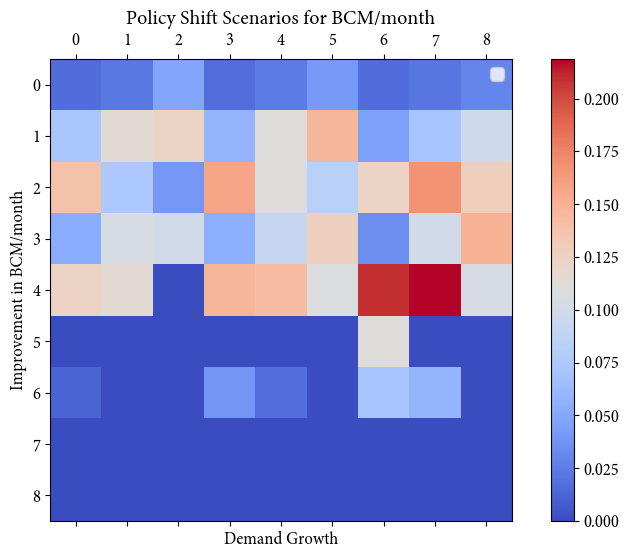

2it [00:11,  5.76s/it]

------------
sudan_irr
------------



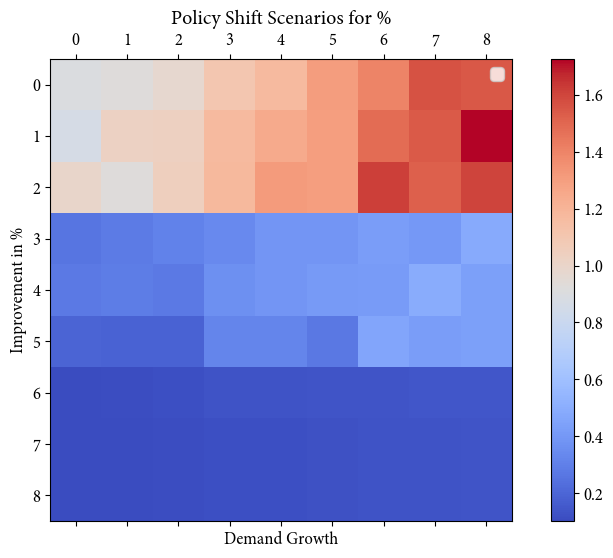

3it [00:17,  5.81s/it]

------------
ethiopia_hydro
------------



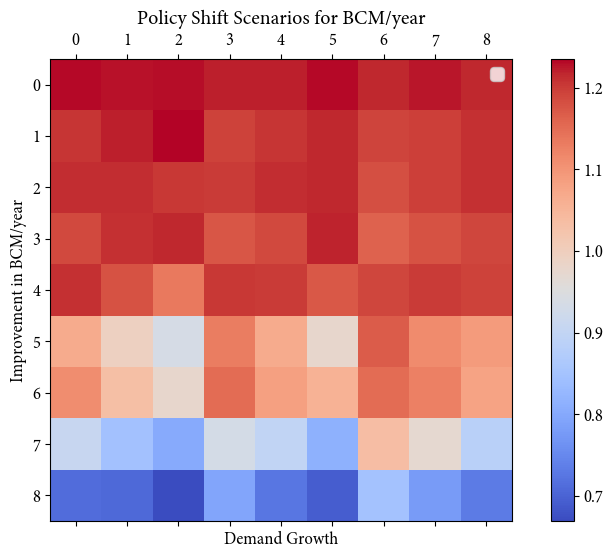

4it [00:23,  5.80s/it]


In [25]:
pivot_rows = ["Blue Nile Mean", "White Nile Mean"]
pivot_columns = ["Demand Growth", "Atbara Mean"]

policy_colors = {
    "Best Egypt HAD": "#6C0C86",
    "Compromise: Absolute": "orchid",
    "Best Ethiopia Hydropower": "#41ab5d",
    "Best Egypt Irr.": "#fdaa09",
    "Best Sudan Irr.": "#000000",
    "Compromise: Percentile": "chocolate",
}
units = ["BCM/year", "BCM/month", "%", "BCM/year", "BCM/month", "TWh/year"]

def plot_policy_shift_scenarios(pvt_policy_names, pvt_improvement, unit):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Example plot, adjust as necessary for your specific data
    cax = ax.matshow(pvt_improvement, cmap='coolwarm')
    fig.colorbar(cax)
    
    # Customize the legend
    handles, labels = ax.get_legend_handles_labels()
    for handle in handles:
        if hasattr(handle, 'set_markersize'):
            handle.set_markersize(10)
    
    ax.legend(handles, labels, loc='best')
    plt.title(f"Policy Shift Scenarios for {unit}")
    plt.xlabel("Demand Growth")
    plt.ylabel(f"Improvement in {unit}")
    
    return fig

for u, obj in tqdm(enumerate(outcomes.iloc[:, :-2].columns)):
    print("------------")
    print(obj)
    print("------------\n")
    
    pvt_policy_names = pd.pivot_table(
        best_performer_df.loc[:, pivot_rows + pivot_columns + [obj]],
        values=obj,
        index=pivot_rows,
        columns=pivot_columns,
        aggfunc=lambda x: statistics.mode(x),
        dropna=False,
    )

    best_performer_df[f"scenario_box_best_{obj}"] = range(5000)
    for i in range(5000):
        best_performer_df.loc[i, f"scenario_box_best_{obj}"] = pvt_policy_names.loc[
            (
                best_performer_df.loc[i, "Blue Nile Mean"],
                best_performer_df.loc[i, "White Nile Mean"],
            ),
            (
                best_performer_df.loc[i, "Demand Growth"],
                best_performer_df.loc[i, "Atbara Mean"],
            ),
        ]
        if (
            best_performer_df.loc[i, obj]
            != best_performer_df.loc[i, f"scenario_box_best_{obj}"]
        ):
            best_performer_df.loc[i, f"{obj}_improvement"] = None

    pvt_improvement = pd.pivot_table(
        best_performer_df.loc[:, pivot_rows + pivot_columns + [f"{obj}_improvement"]],
        values=f"{obj}_improvement",
        index=pivot_rows,
        columns=pivot_columns,
        aggfunc=lambda x: x.mean(),
        dropna=False,
    )

    if obj != "sudan_90":
        fig = plot_policy_shift_scenarios(pvt_policy_names, pvt_improvement, units[u])
        plt.savefig(
            f"../plots/scenario_analysis/{obj}_best_performer_under_uncertainty.svg",
            bbox_inches="tight",
        )
        plt.show()


0it [00:00, ?it/s]

------------
egypt_irr
------------



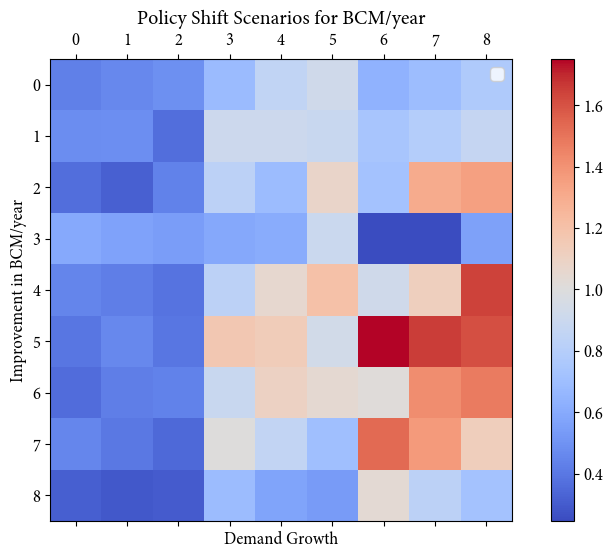

1it [00:05,  5.87s/it]

------------
egypt_low_had
------------



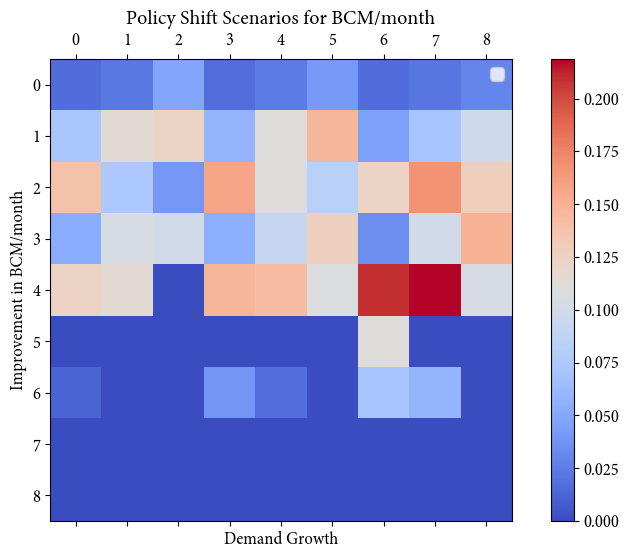

2it [00:11,  5.72s/it]

------------
sudan_irr
------------



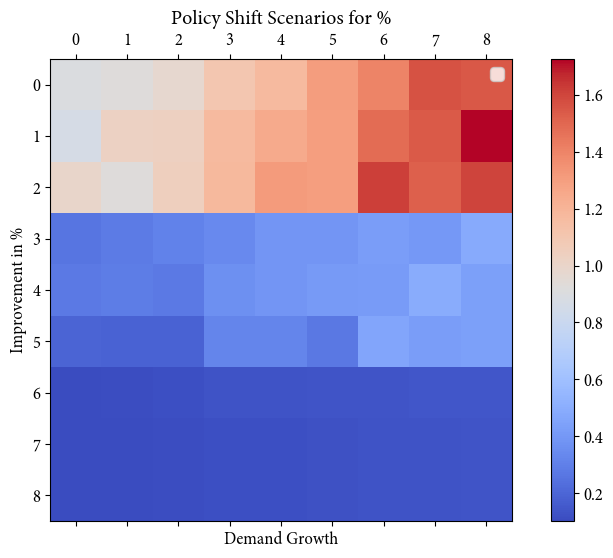

3it [00:16,  5.51s/it]

------------
ethiopia_hydro
------------



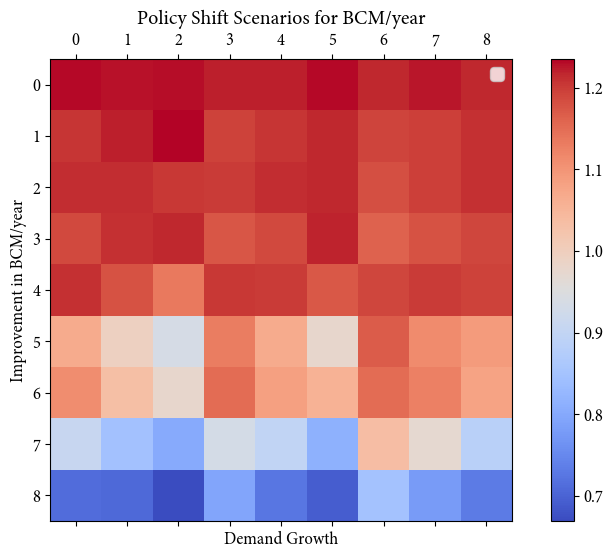

4it [00:22,  5.54s/it]


In [26]:
pivot_rows = ["Blue Nile Mean", "White Nile Mean"]
pivot_columns = ["Demand Growth", "Atbara Mean"]

policy_colors = {
    "Best Egypt 90$^{th}$": "#0195fb",
    "Best Egypt HAD": "#6C0C86",
    "Compromise: Absolute": "orchid",
    "Best Ethiopia Hydropower": "#41ab5d",
    "Best Egypt Irr.": "#fdaa09",
    "Compromise: Percentile": "chocolate",
}
units = ["BCM/year", "BCM/month", "%", "BCM/year", "BCM/month", "TWh/year"]

for u, obj in tqdm(enumerate(outcomes.iloc[:, :-2].columns)):
    print("------------")
    print(obj)
    print("------------\n")
    pvt_policy_names = pd.pivot_table(
        best_performer_df.loc[:, pivot_rows + pivot_columns + [obj]],
        values=obj,
        index=pivot_rows,
        columns=pivot_columns,
        aggfunc=lambda x: statistics.mode(x),
        dropna=False,
    )

    best_performer_df[f"scenario_box_best_{obj}"] = range(5000)
    for i in range(5000):
        best_performer_df.loc[i, f"scenario_box_best_{obj}"] = pvt_policy_names.loc[
            (
                best_performer_df.loc[i, "Blue Nile Mean"],
                best_performer_df.loc[i, "White Nile Mean"],
            ),
            (
                best_performer_df.loc[i, "Demand Growth"],
                best_performer_df.loc[i, "Atbara Mean"],
            ),
        ]
        if (
            best_performer_df.loc[i, obj]
            != best_performer_df.loc[i, f"scenario_box_best_{obj}"]
        ):
            best_performer_df.loc[i, f"{obj}_improvement"] = None

    pvt_improvement = pd.pivot_table(
        best_performer_df.loc[:, pivot_rows + pivot_columns + [f"{obj}_improvement"]],
        values=f"{obj}_improvement",
        index=pivot_rows,
        columns=pivot_columns,
        aggfunc=lambda x: x.mean(),
        dropna=False,
    )

    if obj != "sudan_90":
        plot_policy_shift_scenarios(pvt_policy_names, pvt_improvement, units[u])
        plt.savefig(
            f"../plots/scenario_analysis/{obj}_best_performer_under_uncertainty.svg",
            bbox_inches="tight",
        )
        plt.show()

0it [00:00, ?it/s]

------------
egypt_irr
------------



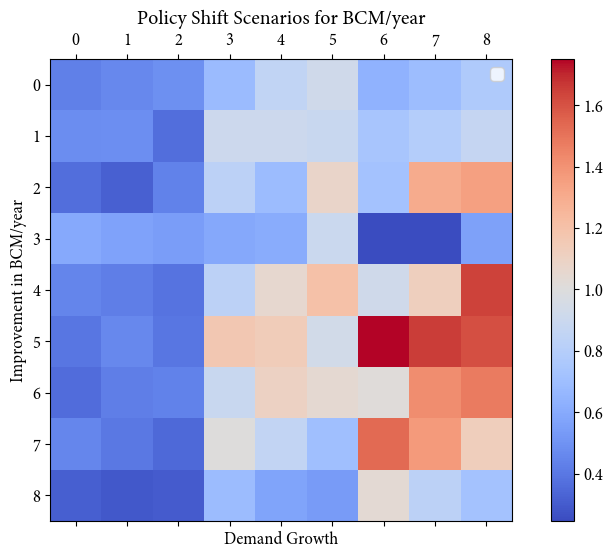

1it [00:05,  6.00s/it]

------------
egypt_low_had
------------



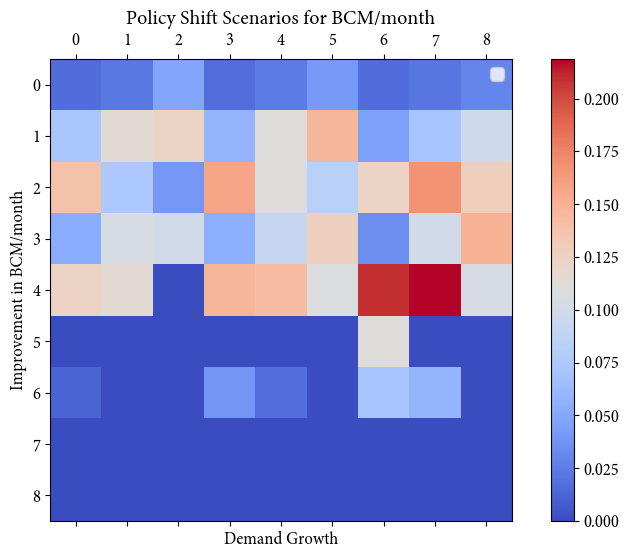

2it [00:11,  5.80s/it]

------------
sudan_irr
------------



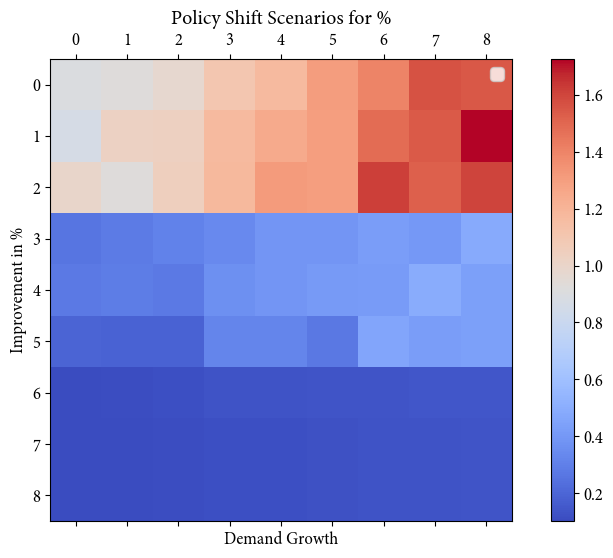

3it [00:17,  5.66s/it]

------------
ethiopia_hydro
------------



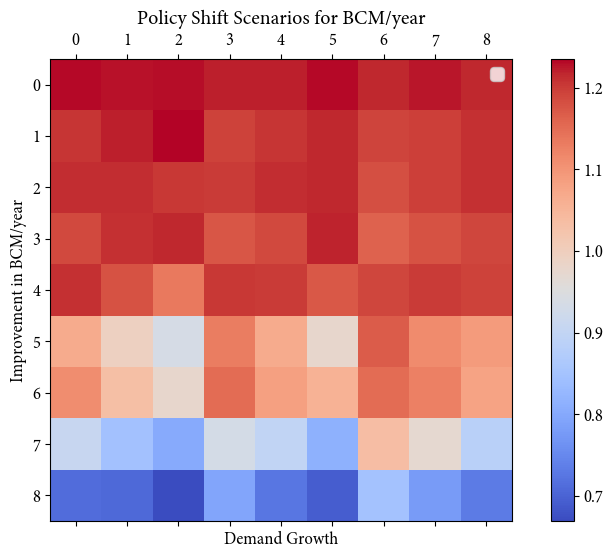

4it [00:22,  5.71s/it]


In [34]:
pivot_rows = ["Blue Nile Mean", "White Nile Mean"]
pivot_columns = ["Demand Growth", "Atbara Mean"]

policy_colors = {
    "Best Egypt 90$^{th}$": "#0195fb",
    "Best Egypt HAD": "#6C0C86",
    "Compromise: Absolute": "orchid",
    "Best Ethiopia Hydropower": "#41ab5d",
    "Best Egypt Irr.": "#fdaa09",
    "Compromise: Percentile": "chocolate",
}
units = ["BCM/year", "BCM/month", "%", "BCM/year", "BCM/month", "TWh/year"]

for u, obj in tqdm(enumerate(outcomes.iloc[:, :-2].columns)):
    print("------------")
    print(obj)
    print("------------\n")
    pvt_policy_names = pd.pivot_table(
        best_performer_df.loc[:, pivot_rows + pivot_columns + [obj]],
        values=obj,
        index=pivot_rows,
        columns=pivot_columns,
        aggfunc=lambda x: statistics.mode(x),
        dropna=False,
    )

    best_performer_df[f"scenario_box_best_{obj}"] = range(5000)
    for i in range(5000):
        best_performer_df.loc[i, f"scenario_box_best_{obj}"] = pvt_policy_names.loc[
            (
                best_performer_df.loc[i, "Blue Nile Mean"],
                best_performer_df.loc[i, "White Nile Mean"],
            ),
            (
                best_performer_df.loc[i, "Demand Growth"],
                best_performer_df.loc[i, "Atbara Mean"],
            ),
        ]
        if (
            best_performer_df.loc[i, obj]
            != best_performer_df.loc[i, f"scenario_box_best_{obj}"]
        ):
            best_performer_df.loc[i, f"{obj}_improvement"] = None

    pvt_improvement = pd.pivot_table(
        best_performer_df.loc[:, pivot_rows + pivot_columns + [f"{obj}_improvement"]],
        values=f"{obj}_improvement",
        index=pivot_rows,
        columns=pivot_columns,
        aggfunc=lambda x: x.mean(),
        dropna=False,
    )

    if obj != "sudan_90":
        plot_policy_shift_scenarios(pvt_policy_names, pvt_improvement, units[u])
        plt.savefig(
            f"../plots/scenario_analysis/{obj}_best_performer_under_uncertainty.svg",
            bbox_inches="tight",
        )
        plt.show()